# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


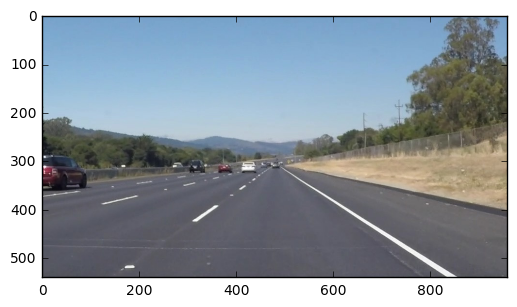

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

### Working against test images
#### Peak on testing images.
Testing images were first examined to see what features they have and whether they are of uniform size. The sizes are expected to be the same for all images since a vehicle will be recording with the same recording device.

Image size of  solidWhiteCurve.jpg is  (540, 960, 3)
Image size of  solidWhiteRight.jpg is  (540, 960, 3)
Image size of  solidYellowCurve.jpg is  (540, 960, 3)
Image size of  solidYellowCurve2.jpg is  (540, 960, 3)
Image size of  solidYellowLeft.jpg is  (540, 960, 3)
Image size of  whiteCarLaneSwitch.jpg is  (540, 960, 3)


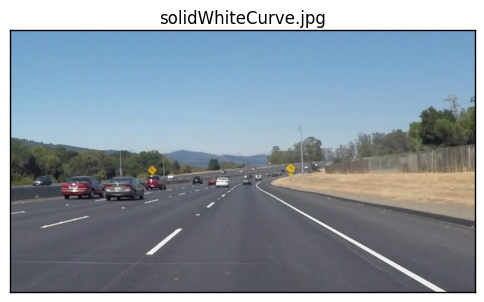

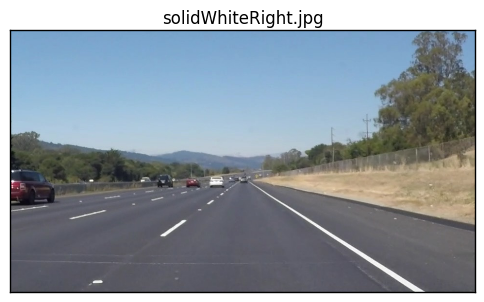

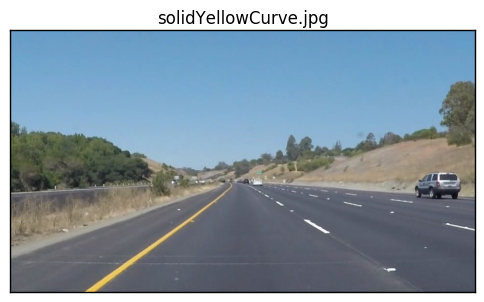

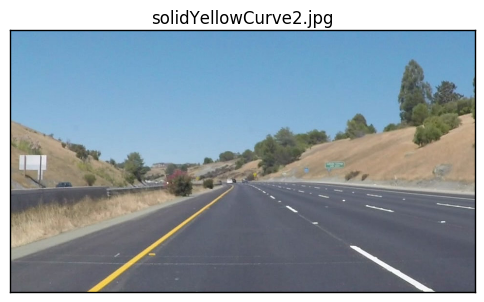

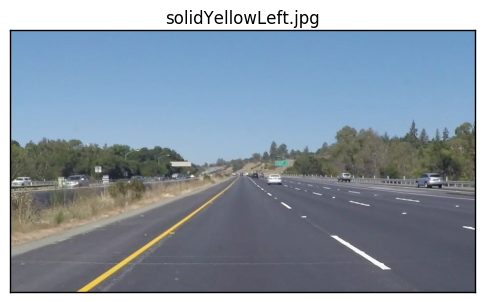

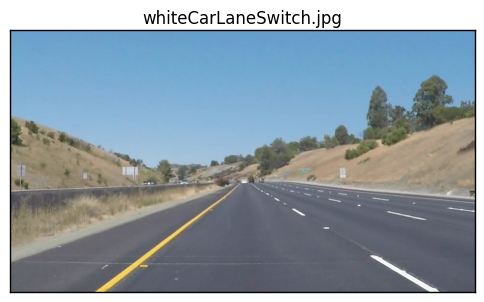

In [60]:
img_list = os.listdir("test_images/")

for img_name in img_list:
    img = mpimg.imread('test_images/' + img_name)
    print('Image size of ',img_name, 'is ', img.shape)
    
    # Plot images to get an idea of what they look like
    
    plt.figure()
    plt.imshow(img)
    plt.xticks([]); plt.yticks([])
    plt.title(img_name)

All images seem relatively the same (dark gray road with yellow/white lanes and a blue sky).
As expected, sizes of the images were the same.

#### Experimenting with Color Selection (Not used for lane detection. Left just for reference.)
Filtering out target objects by colors will enhance the lane detection process. The testing images above show that yellow and white are two main colors of lanes. Since the two colors cannot be detected simultaneously, they will have be filtered out with two separate filters.

Having only maximum thresholds suffice for filtering out white color.  
Filtering out yellow can be done by having minimum and maximum thresholds. 
reference: [Distinguishing colors of Gameboy catridges](http://www.pyimagesearch.com/2014/08/04/opencv-python-color-detection/)


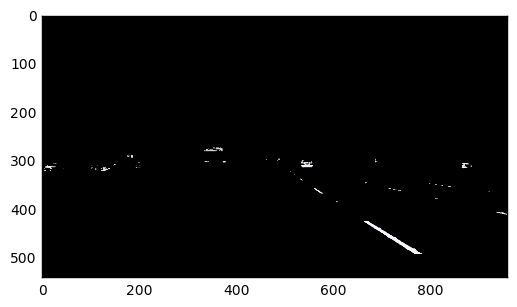

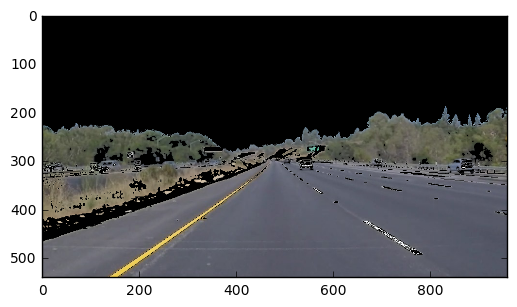

In [61]:
# Parameters for Color Selection
white_filter_threshold = [200, 200, 200]
yellow_filter_threshold = [[25, 146, 190], [62, 174, 250]]

# Read image file - solidYellowLeft.jpg
image = mpimg.imread('test_images/solidYellowLeft.jpg')

def ColorSelection(image):
    white_only = np.copy(image)
    yellow_only = np.copy(image)

    white_thresh = (image[:,:,0] < white_filter_threshold[0]) \
            | (image[:,:,1] < white_filter_threshold[1]) \
            | (image[:,:,2] < white_filter_threshold[2])

    yellow_thresh = ((image[:,:,0] > yellow_filter_threshold[0][0]) \
            & (image[:,:,0] < yellow_filter_threshold[1][0])) \
            | ((image[:,:,1] > yellow_filter_threshold[0][1]) \
            & (image[:,:,1] < yellow_filter_threshold[1][1])) \
            | ((image[:,:,2] > yellow_filter_threshold[0][2]) \
            & (image[:,:,2] < yellow_filter_threshold[1][2]))

    white_only[white_thresh] = [0,0,0]
    yellow_only[yellow_thresh] = [0,0,0]
    
    return [white_only, yellow_only]
    
white, yellow = ColorSelection(image)
plt.imshow(white)
plt.figure()
plt.imshow(yellow)

#### Experimenting with Masking  
Separating a subarea of an image with useful information can enhance lane detection process. The testing images above show that working with a trapezoid shaped mask that sits in the lower 1/3 of image will (hypothetically) work the best for lane detection. 

Test images have height of 540 and width of 960 



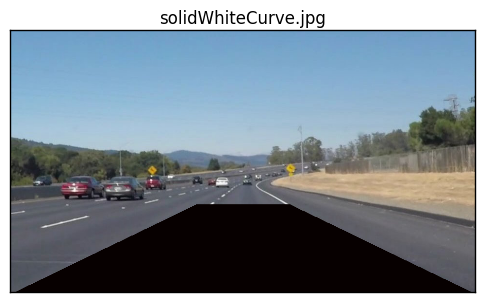

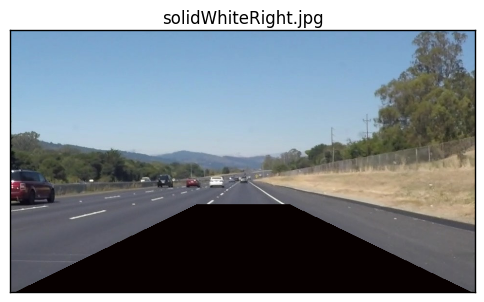

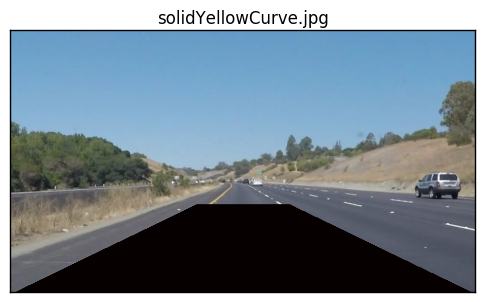

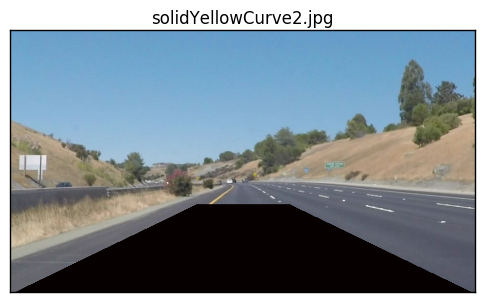

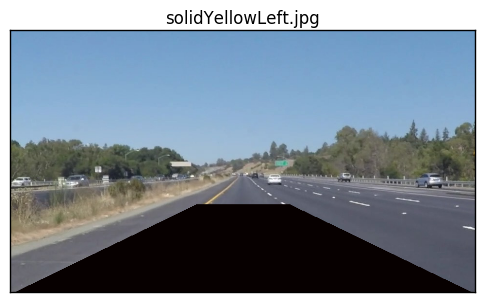

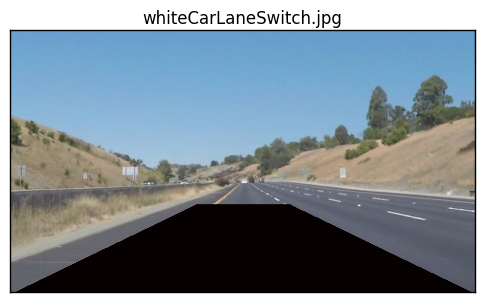

In [70]:
# Check the image dimensions.
img_list = os.listdir("test_images/")
sample_img = mpimg.imread('test_images/' + img_list[0])
height, width, depth = sample_img.shape
print('Test images have height of', height, 'and width of', width, '\n')

# Create mask 
ignore_mask_color = 255   
imshape = image.shape

top_left = (width/2 - width/10 , (2*height)/3)
top_right = (width/2 + width/10, (2*height)/3)
bottom_left = (10, height)
bottom_right = (width - 10 , height)

vertices = np.array([[top_right, top_left, bottom_left, bottom_right]], dtype=np.int32)

# Apply trapezoid shaped mask to every image
for img_name in img_list:
    
    # Read image file
    image = mpimg.imread('test_images/' + img_name)

    third_height = int((2*height)/3)
    cv2.fillPoly(image, vertices , 7)

    plt.figure()
    plt.imshow(image)
    plt.xticks([]); plt.yticks([])
    plt.title(img_name)

The single trapezoid mask generated seems to fit well all testing images available.  
Now, the mask will be used to process images for lane detection.  
Images will go through:
Gray Scaling > Gaussian Smoothing > Canny Edge Detection > Hough Transformation

A helper function `group_lines` takes as inputs detected `lines` information, clusters them by slopes (negative or positive), then outputs a single line per cluster that best represents the cluster.

shape (540, 960, 3)


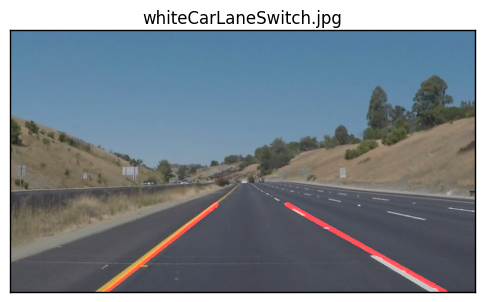

In [74]:
# Initialize line_image
line_image = np.copy(image)*0 

# Parameter for Gaussian Smoothing
kernel_size = 5

# Parameters for Canny Edge Detection
low_threshold = 50
high_threshold = 150

# Parameters for Hough Transformation
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 3    # minimum number of votes (intersections in Hough grid cell)
min_line_length = 12 #minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments

# Helper function: group_lines(slopes)
# This will cluster slopes into two similar groups and output two lines, one representing each group.
def group_lines(lines):
    slopes = []
    coords = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            slopes.append(slope)
            coords.append([x1, y1])
    
    grp1_slopes = []; grp2_slopes = []
    grp1_coords = []; grp2_coords = []
    
    for idx, slope in enumerate(slopes):
        if slope > 0 :
            grp1_slopes.append(slope)
            grp1_coords.append(coords[idx])
        elif slope < 0:
            grp2_slopes.append(slope)
            grp2_coords.append(coords[idx])
            
    x_grp1, y_grp1 = grp1_coords[0]
    x_grp2, y_grp2 = grp2_coords[0]
    
    slope_grp1 = np.mean(grp1_slopes)
    slope_grp2 = np.mean(grp2_slopes)
    
    # from known slope and a point, calculate the other point on line
    new_grp1_coords = [int(round((height-y_grp1)/slope_grp1+x_grp1)), height, int(round((2*height/3-y_grp1)/slope_grp1+x_grp1)), int(round(2*height/3))]
    new_grp2_coords = [int(round((height-y_grp2)/slope_grp2+x_grp2)), height, int(round((2*height/3-y_grp2)/slope_grp2+x_grp2)), int(round(2*height/3))]
    
    return np.array([[new_grp1_coords], [new_grp2_coords]], dtype=np.int32)
    

image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
 
image_work = np.copy(image)

# GrayScale
gray = cv2.cvtColor(image_work,cv2.COLOR_RGB2GRAY)


# Gaussian Blur
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)


# Canny Edge Detection
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)


# Masking with four sided polygon
mask = np.zeros_like(edges)   
ignore_mask_color = 255 

imshape = image.shape
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)


# Hough Transformation
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)


# Implement the helper function here!
new_lines = []
new_lines = group_lines(lines)

for line in new_lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

        
# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 


# Draw the lines on the edge image
lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0) 


plt.figure()
plt.imshow(lines_edges)
plt.xticks([]); plt.yticks([])
plt.title(img_name)

print('shape', lines_edges.shape)

Apply GrayScale > GaussianBlur > CannyEdgeDetection

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [75]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [76]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    image_work = np.copy(image)

    # GrayScale
    gray = cv2.cvtColor(image_work,cv2.COLOR_RGB2GRAY)


    # Gaussian Blur
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)


    # Canny Edge Detection
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)


    # Masking with four sided polygon
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255 

    imshape = image.shape
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)


    # Hough Transformation
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    # Implement the helper function here!
    new_lines = group_lines(lines)

    for line in new_lines:
        print(line)
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)


    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 


    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    result = lines_edges
    return result

Let's try the one with the solid white lane on the right first ...

In [77]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[[871 540 572 360]]
[[145 540 404 360]]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4






  0%|          | 0/222 [00:00<?, ?it/s]



  1%|▏         | 3/222 [00:00<00:10, 21.87it/s]

[[871 540 572 360]]
[[145 540 404 360]]
[[867 540 573 360]]
[[166 540 413 360]]
[[865 540 576 360]]
[[149 540 382 360]]
[[859 540 564 360]]
[[168 540 409 360]]


[[863 540 565 360]]
[[168 540 405 360]]






  3%|▎         | 6/222 [00:00<00:09, 23.31it/s]



  4%|▍         | 9/222 [00:00<00:08, 24.22it/s]

[[867 540 582 360]]
[[153 540 398 360]]
[[856 540 565 360]]
[[186 540 400 360]]
[[868 540 557 360]]
[[159 540 390 360]]
[[914 540 565 360]]
[[143 540 396 360]]
[[852 540 562 360]]
[[156 540 410 360]]
[[859 540 566 360]]
[[156 540 397 360]]






  5%|▌         | 12/222 [00:00<00:08, 25.24it/s]



  7%|▋         | 15/222 [00:00<00:08, 24.21it/s]

[[865 540 561 360]]
[[151 540 397 360]]
[[847 540 566 360]]
[[146 540 399 360]]
[[841 540 557 360]]
[[140 540 413 360]]
[[843 540 565 360]]
[[157 540 403 360]]
[[849 540 567 360]]
[[152 540 392 360]]






  8%|▊         | 18/222 [00:00<00:08, 24.39it/s]



  9%|▉         | 21/222 [00:00<00:08, 24.90it/s]

[[864 540 573 360]]
[[135 540 393 360]]
[[852 540 574 360]]
[[129 540 404 360]]
[[859 540 570 360]]
[[156 540 394 360]]
[[857 540 562 360]]
[[121 540 422 360]]
[[842 540 560 360]]
[[122 540 411 360]]
[[843 540 560 360]]
[[164 540 410 360]]






 11%|█▏        | 25/222 [00:00<00:07, 26.08it/s]



 13%|█▎        | 28/222 [00:01<00:07, 26.88it/s]

[[847 540 569 360]]
[[153 540 419 360]]
[[840 540 554 360]]
[[150 540 425 360]]
[[847 540 552 360]]
[[159 540 414 360]]
[[848 540 561 360]]
[[160 540 408 360]]
[[845 540 562 360]]
[[141 540 386 360]]
[[850 540 569 360]]
[[162 540 427 360]]






 14%|█▍        | 31/222 [00:01<00:06, 27.73it/s]



 15%|█▌        | 34/222 [00:01<00:06, 28.36it/s]

[[851 540 562 360]]
[[155 540 411 360]]
[[851 540 554 360]]
[[157 540 408 360]]
[[861 540 563 360]]
[[164 540 407 360]]
[[842 540 555 360]]
[[ 85 540 418 360]]
[[844 540 562 360]]
[[140 540 411 360]]
[[856 540 568 360]]
[[148 540 393 360]]






 17%|█▋        | 37/222 [00:01<00:07, 24.27it/s]

[[854 540 570 360]]
[[150 540 389 360]]
[[854 540 566 360]]
[[147 540 395 360]]
[[851 540 566 360]]
[[144 540 396 360]]
[[844 540 568 360]]
[[143 540 403 360]]
[[841 540 560 360]]
[[162 540 407 360]]






 18%|█▊        | 41/222 [00:01<00:06, 26.71it/s]



 20%|█▉        | 44/222 [00:01<00:06, 26.27it/s]

[[853 540 570 360]]
[[145 540 399 360]]
[[859 540 569 360]]
[[151 540 398 360]]
[[855 540 571 360]]
[[157 540 394 360]]
[[830 540 568 360]]
[[155 540 395 360]]
[[853 540 571 360]]
[[141 540 408 360]]
[[849 540 572 360]]
[[118 540 413 360]]
[[838 540 564 360]]






 21%|██        | 47/222 [00:01<00:07, 22.22it/s]

[[156 540 390 360]]
[[855 540 570 360]]
[[166 540 399 360]]
[[845 540 566 360]]
[[149 540 386 360]]
[[851 540 556 360]]
[[141 540 390 360]]






 23%|██▎       | 50/222 [00:01<00:07, 24.06it/s]



 24%|██▍       | 53/222 [00:02<00:07, 23.89it/s]

[[851 540 562 360]]
[[158 540 409 360]]
[[841 540 552 360]]
[[138 540 390 360]]
[[857 540 567 360]]
[[134 540 381 360]]
[[847 540 565 360]]
[[147 540 402 360]]
[[853 540 572 360]]
[[149 540 401 360]]
[[858 540 567 360]]
[[142 540 402 360]]






 25%|██▌       | 56/222 [00:02<00:06, 24.94it/s]



 27%|██▋       | 59/222 [00:02<00:06, 24.67it/s]

[[874 540 568 360]]
[[150 540 390 360]]
[[837 540 560 360]]
[[117 540 400 360]]
[[831 540 555 360]]
[[138 540 394 360]]
[[852 540 567 360]]
[[157 540 396 360]]
[[832 540 559 360]]
[[156 540 390 360]]
[[835 540 558 360]]
[[150 540 407 360]]






 28%|██▊       | 62/222 [00:02<00:06, 25.16it/s]



 29%|██▉       | 65/222 [00:02<00:06, 25.17it/s]

[[840 540 569 360]]
[[143 540 394 360]]
[[843 540 556 360]]
[[129 540 392 360]]
[[831 540 550 360]]
[[129 540 391 360]]
[[842 540 571 360]]
[[162 540 399 360]]
[[824 540 556 360]]
[[143 540 391 360]]
[[829 540 559 360]]
[[142 540 399 360]]






 31%|███       | 69/222 [00:02<00:05, 25.53it/s]



 33%|███▎      | 73/222 [00:02<00:05, 27.19it/s]

[[842 540 567 360]]
[[128 540 391 360]]
[[840 540 559 360]]
[[137 540 401 360]]
[[842 540 567 360]]
[[114 540 397 360]]
[[828 540 559 360]]
[[133 540 410 360]]
[[829 540 558 360]]
[[141 540 395 360]]
[[829 540 558 360]]
[[123 540 386 360]]






 34%|███▍      | 76/222 [00:02<00:05, 25.03it/s]

[[849 540 558 360]]
[[140 540 421 360]]
[[843 540 563 360]]
[[142 540 397 360]]
[[839 540 569 360]]
[[136 540 409 360]]
[[833 540 566 360]]
[[111 540 393 360]]
[[825 540 558 360]]
[[147 540 394 360]]
[[844 540 562 360]]
[[126 540 400 360]]
[[842 540 554 360]]
[[119 540 388 360]]






 36%|███▌      | 80/222 [00:03<00:05, 27.27it/s]



 37%|███▋      | 83/222 [00:03<00:05, 27.02it/s]



 39%|███▉      | 87/222 [00:03<00:04, 28.92it/s]

[[830 540 565 360]]
[[ 88 540 418 360]]
[[822 540 543 360]]
[[122 540 384 360]]
[[834 540 561 360]]
[[111 540 397 360]]
[[822 540 550 360]]
[[122 540 380 360]]
[[813 540 558 360]]
[[117 540 388 360]]
[[824 540 562 360]]
[[116 540 376 360]]
[[820 540 556 360]]
[[116 540 385 360]]






 41%|████      | 90/222 [00:03<00:04, 26.59it/s]

[[828 540 552 360]]
[[138 540 399 360]]
[[821 540 555 360]]
[[115 540 384 360]]
[[828 540 548 360]]
[[135 540 401 360]]
[[812 540 555 360]]
[[114 540 395 360]]
[[821 540 557 360]]
[[ 99 540 403 360]]
[[837 540 557 360]]
[[ 99 540 403 360]]






 42%|████▏     | 94/222 [00:03<00:04, 28.15it/s]

[[817 540 546 360]]
[[131 540 403 360]]
[[816 540 560 360]]
[[133 540 381 360]]
[[834 540 566 360]]
[[120 540 392 360]]
[[828 540 570 360]]






 44%|████▎     | 97/222 [00:03<00:05, 21.61it/s]



 45%|████▌     | 100/222 [00:03<00:05, 22.36it/s]

[[116 540 399 360]]
[[827 540 575 360]]
[[134 540 424 360]]
[[818 540 564 360]]
[[133 540 411 360]]
[[833 540 570 360]]
[[133 540 410 360]]






 46%|████▋     | 103/222 [00:04<00:05, 20.66it/s]



 48%|████▊     | 106/222 [00:04<00:05, 22.29it/s]

[[829 540 570 360]]
[[114 540 396 360]]
[[823 540 568 360]]
[[126 540 397 360]]
[[830 540 573 360]]
[[161 540 403 360]]
[[817 540 562 360]]
[[123 540 400 360]]
[[840 540 568 360]]
[[128 540 398 360]]
[[820 540 559 360]]
[[140 540 407 360]]






 49%|████▉     | 109/222 [00:04<00:04, 23.13it/s]



 50%|█████     | 112/222 [00:04<00:04, 24.19it/s]

[[828 540 564 360]]
[[137 540 414 360]]
[[833 540 581 360]]
[[128 540 421 360]]
[[821 540 556 360]]
[[141 540 392 360]]
[[825 540 563 360]]
[[152 540 401 360]]
[[822 540 563 360]]
[[150 540 410 360]]
[[822 540 564 360]]
[[153 540 404 360]]






 52%|█████▏    | 115/222 [00:04<00:04, 23.49it/s]

[[831 540 565 360]]
[[151 540 412 360]]
[[836 540 565 360]]
[[144 540 404 360]]
[[845 540 573 360]]
[[ 88 540 405 360]]
[[847 540 573 360]]
[[146 540 403 360]]






 53%|█████▎    | 118/222 [00:04<00:05, 20.52it/s]



 55%|█████▍    | 121/222 [00:04<00:04, 22.31it/s]

[[850 540 575 360]]
[[112 540 399 360]]
[[847 540 579 360]]
[[137 540 393 360]]
[[851 540 574 360]]
[[150 540 401 360]]
[[852 540 572 360]]
[[142 540 412 360]]
[[834 540 564 360]]
[[148 540 411 360]]
[[838 540 564 360]]
[[130 540 393 360]]






 56%|█████▌    | 124/222 [00:05<00:04, 21.55it/s]



 57%|█████▋    | 127/222 [00:05<00:04, 23.25it/s]

[[832 540 555 360]]
[[151 540 401 360]]
[[837 540 565 360]]
[[149 540 415 360]]
[[851 540 572 360]]
[[127 540 387 360]]
[[841 540 566 360]]
[[151 540 400 360]]
[[857 540 573 360]]
[[142 540 400 360]]






 59%|█████▊    | 130/222 [00:05<00:03, 23.63it/s]



 60%|█████▉    | 133/222 [00:05<00:03, 24.77it/s]

[[883 540 572 360]]
[[132 540 403 360]]
[[855 540 571 360]]
[[123 540 409 360]]
[[854 540 571 360]]
[[150 540 401 360]]
[[849 540 561 360]]
[[148 540 401 360]]
[[854 540 570 360]]
[[147 540 405 360]]
[[861 540 570 360]]
[[162 540 416 360]]






 61%|██████▏   | 136/222 [00:05<00:03, 23.13it/s]

[[844 540 573 360]]
[[145 540 389 360]]
[[862 540 574 360]]
[[140 540 405 360]]
[[863 540 576 360]]
[[138 540 391 360]]
[[849 540 569 360]]
[[157 540 404 360]]
[[854 540 569 360]]
[[143 540 408 360]]
[[868 540 569 360]]
[[147 540 407 360]]
[[849 540 565 360]]
[[133 540 419 360]]






 63%|██████▎   | 140/222 [00:05<00:03, 25.09it/s]



 64%|██████▍   | 143/222 [00:05<00:03, 23.58it/s]

[[865 540 562 360]]
[[168 540 410 360]]
[[840 540 566 360]]
[[174 540 410 360]]
[[842 540 563 360]]
[[166 540 416 360]]
[[850 540 559 360]]
[[164 540 397 360]]
[[864 540 570 360]]
[[166 540 419 360]]






 66%|██████▌   | 146/222 [00:05<00:03, 23.85it/s]



 67%|██████▋   | 149/222 [00:06<00:03, 23.97it/s]

[[848 540 560 360]]
[[168 540 424 360]]
[[852 540 569 360]]
[[149 540 410 360]]
[[855 540 570 360]]
[[170 540 405 360]]
[[857 540 568 360]]
[[167 540 410 360]]






 68%|██████▊   | 152/222 [00:06<00:03, 21.01it/s]

[[860 540 572 360]]
[[121 540 422 360]]
[[876 540 574 360]]
[[169 540 414 360]]
[[856 540 561 360]]
[[171 540 414 360]]
[[868 540 578 360]]
[[175 540 411 360]]






 70%|██████▉   | 155/222 [00:06<00:03, 20.82it/s]

[[871 540 572 360]]
[[177 540 411 360]]
[[860 540 568 360]]
[[169 540 412 360]]
[[857 540 560 360]]
[[158 540 397 360]]
[[871 540 580 360]]
[[159 540 393 360]]
[[877 540 582 360]]
[[168 540 420 360]]






 71%|███████   | 158/222 [00:06<00:03, 19.80it/s]



 73%|███████▎  | 161/222 [00:06<00:02, 21.56it/s]



 74%|███████▍  | 164/222 [00:06<00:02, 23.52it/s]

[[895 540 579 360]]
[[175 540 413 360]]
[[882 540 578 360]]
[[170 540 414 360]]
[[877 540 580 360]]
[[157 540 393 360]]
[[898 540 559 360]]
[[177 540 409 360]]
[[879 540 574 360]]
[[158 540 412 360]]
[[881 540 581 360]]
[[179 540 409 360]]






 75%|███████▌  | 167/222 [00:06<00:02, 23.32it/s]

[[906 540 574 360]]
[[182 540 406 360]]
[[883 540 578 360]]
[[133 540 427 360]]
[[879 540 567 360]]
[[174 540 430 360]]
[[875 540 567 360]]
[[178 540 405 360]]






 77%|███████▋  | 170/222 [00:07<00:02, 19.06it/s]

[[879 540 575 360]]
[[185 540 424 360]]
[[872 540 567 360]]
[[170 540 415 360]]
[[874 540 566 360]]
[[192 540 413 360]]
[[877 540 574 360]]
[[191 540 421 360]]






 78%|███████▊  | 173/222 [00:07<00:02, 18.70it/s]

[[886 540 582 360]]
[[190 540 420 360]]
[[874 540 568 360]]
[[165 540 411 360]]
[[872 540 569 360]]
[[186 540 419 360]]
[[883 540 576 360]]
[[188 540 408 360]]






 79%|███████▉  | 176/222 [00:07<00:02, 17.97it/s]



 81%|████████  | 179/222 [00:07<00:02, 19.22it/s]



 82%|████████▏ | 183/222 [00:07<00:01, 22.15it/s]

[[872 540 566 360]]
[[170 540 430 360]]
[[875 540 569 360]]
[[190 540 420 360]]
[[889 540 564 360]]
[[188 540 404 360]]
[[875 540 570 360]]
[[182 540 405 360]]
[[886 540 579 360]]
[[174 540 426 360]]
[[890 540 560 360]]
[[183 540 402 360]]
[[893 540 568 360]]
[[198 540 420 360]]






 84%|████████▍ | 186/222 [00:07<00:01, 23.80it/s]



 85%|████████▌ | 189/222 [00:07<00:01, 24.69it/s]

[[869 540 574 360]]
[[187 540 408 360]]
[[891 540 573 360]]
[[196 540 428 360]]
[[880 540 572 360]]
[[201 540 414 360]]
[[876 540 572 360]]
[[151 540 416 360]]
[[888 540 582 360]]
[[191 540 414 360]]
[[902 540 577 360]]
[[135 540 436 360]]






 86%|████████▋ | 192/222 [00:08<00:01, 21.62it/s]

[[912 540 583 360]]
[[184 540 412 360]]
[[894 540 590 360]]
[[184 540 399 360]]
[[889 540 576 360]]
[[169 540 411 360]]
[[905 540 574 360]]
[[198 540 418 360]]
[[882 540 573 360]]
[[191 540 419 360]]
[[880 540 572 360]]
[[195 540 426 360]]






 88%|████████▊ | 196/222 [00:08<00:01, 24.22it/s]



 90%|████████▉ | 199/222 [00:08<00:01, 21.95it/s]

[[874 540 563 360]]
[[177 540 403 360]]
[[883 540 577 360]]
[[176 540 403 360]]
[[881 540 571 360]]
[[171 540 421 360]]
[[877 540 572 360]]
[[150 540 423 360]]






 91%|█████████ | 202/222 [00:08<00:01, 19.15it/s]

[[891 540 578 360]]
[[168 540 426 360]]
[[889 540 560 360]]
[[176 540 409 360]]
[[882 540 574 360]]
[[172 540 428 360]]
[[886 540 560 360]]
[[185 540 423 360]]






 92%|█████████▏| 205/222 [00:08<00:00, 18.64it/s]

[[899 540 581 360]]
[[193 540 420 360]]
[[902 540 584 360]]
[[192 540 418 360]]
[[923 540 576 360]]
[[176 540 401 360]]
[[886 540 576 360]]
[[193 540 426 360]]






 94%|█████████▎| 208/222 [00:08<00:00, 17.49it/s]



 95%|█████████▍| 210/222 [00:09<00:00, 16.50it/s]

[[889 540 577 360]]
[[182 540 404 360]]
[[894 540 577 360]]
[[197 540 419 360]]
[[905 540 585 360]]
[[182 540 413 360]]
[[899 540 564 360]]
[[164 540 409 360]]






 95%|█████████▌| 212/222 [00:09<00:00, 16.06it/s]



 96%|█████████▋| 214/222 [00:09<00:00, 16.76it/s]

[[900 540 581 360]]
[[188 540 416 360]]
[[905 540 584 360]]
[[160 540 413 360]]
[[899 540 580 360]]
[[163 540 436 360]]
[[911 540 577 360]]
[[194 540 418 360]]






 97%|█████████▋| 216/222 [00:09<00:00, 17.48it/s]



 99%|█████████▊| 219/222 [00:09<00:00, 17.70it/s]

[[884 540 567 360]]
[[190 540 397 360]]
[[905 540 565 360]]
[[181 540 400 360]]
[[895 540 575 360]]
[[179 540 403 360]]
[[885 540 568 360]]
[[197 540 430 360]]
[[900 540 565 360]]
[[175 540 390 360]]






100%|█████████▉| 221/222 [00:09<00:00, 22.90it/s]

[[889 540 569 360]]
[[172 540 402 360]]
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.92 s, sys: 1.37 s, total: 5.29 s
Wall time: 11 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [78]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [58]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[[837 540 568 360]]
[[104 540 388 360]]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4






  0%|          | 0/682 [00:00<?, ?it/s]



  1%|          | 4/682 [00:00<00:19, 35.19it/s]

[[837 540 568 360]]
[[104 540 388 360]]
[[838 540 567 360]]
[[102 540 376 360]]
[[834 540 573 360]]
[[125 540 419 360]]
[[822 540 566 360]]
[[124 540 400 360]]
[[835 540 489 360]]
[[131 540 414 360]]
[[925 540 564 360]]
[[115 540 395 360]]


[[815 540 566 360]]
[[119 540 385 360]]






  1%|          | 8/682 [00:00<00:20, 32.78it/s]



  2%|▏         | 11/682 [00:00<00:21, 31.43it/s]

[[957 540 545 360]]
[[117 540 399 360]]
[[897 540 562 360]]
[[137 540 413 360]]
[[881 540 563 360]]
[[194 540 194 360]]
[[837 540 567 360]]
[[119 540 405 360]]
[[875 540 567 360]]
[[142 540 416 360]]
[[833 540 572 360]]
[[144 540 408 360]]
[[840 540 564 360]]
[[144 540 411 360]]






  2%|▏         | 15/682 [00:00<00:20, 32.15it/s]



  3%|▎         | 18/682 [00:00<00:22, 29.85it/s]

[[854 540 585 360]]
[[146 540 409 360]]
[[853 540 551 360]]
[[128 540 413 360]]
[[868 540 574 360]]
[[150 540 419 360]]
[[997 540 558 360]]
[[149 540 432 360]]
[[873 540 570 360]]
[[133 540 416 360]]
[[851 540 575 360]]






  3%|▎         | 21/682 [00:00<00:24, 26.77it/s]

[[133 540 404 360]]
[[864 540 566 360]]
[[133 540 411 360]]
[[853 540 549 360]]
[[150 540 412 360]]
[[854 540 577 360]]
[[130 540 380 360]]






  4%|▎         | 24/682 [00:00<00:25, 25.46it/s]

[[862 540 579 360]]
[[128 540 400 360]]






  4%|▍         | 27/682 [00:00<00:25, 25.96it/s]

[[857 540 580 360]]
[[131 540 400 360]]
[[858 540 567 360]]
[[156 540 401 360]]
[[874 540 559 360]]
[[140 540 401 360]]
[[873 540 580 360]]
[[136 540 392 360]]
[[874 540 581 360]]
[[158 540 416 360]]


[[880 540 580 360]]
[[159 540 420 360]]






  4%|▍         | 30/682 [00:01<00:25, 25.76it/s]



  5%|▍         | 34/682 [00:01<00:23, 27.59it/s]

[[906 540 579 360]]
[[137 540 417 360]]
[[895 540 576 360]]
[[161 540 430 360]]
[[900 540 568 360]]
[[161 540 430 360]]
[[903 540 574 360]]
[[126 540 408 360]]
[[933 540 557 360]]
[[145 540 399 360]]
[[894 540 576 360]]
[[143 540 381 360]]






  5%|▌         | 37/682 [00:01<00:22, 28.09it/s]

[[882 540 564 360]]
[[165 540 413 360]]






  6%|▌         | 40/682 [00:01<00:24, 26.69it/s]

[[896 540 559 360]]
[[144 540 385 360]]
[[894 540 575 360]]
[[165 540 405 360]]
[[875 540 562 360]]
[[164 540 404 360]]
[[882 540 583 360]]
[[142 540 386 360]]
[[883 540 583 360]]
[[162 540 401 360]]


[[935 540 571 360]]
[[140 540 399 360]]






  6%|▋         | 44/682 [00:01<00:23, 27.42it/s]

[[897 540 570 360]]
[[162 540 418 360]]
[[866 540 570 360]]
[[142 540 392 360]]
[[897 540 470 360]]
[[144 540 400 360]]
[[866 540 566 360]]
[[143 540 444 360]]






  7%|▋         | 47/682 [00:01<00:27, 23.04it/s]



  7%|▋         | 50/682 [00:01<00:28, 22.35it/s]

[[867 540 581 360]]
[[155 540 405 360]]
[[873 540 565 360]]
[[163 540 434 360]]
[[908 540 559 360]]
[[162 540 399 360]]
[[881 540 578 360]]
[[141 540 406 360]]
[[885 540 571 360]]
[[159 540 408 360]]






  8%|▊         | 53/682 [00:02<00:29, 21.53it/s]



  8%|▊         | 56/682 [00:02<00:31, 19.65it/s]

[[868 540 568 360]]
[[139 540 389 360]]
[[856 540 567 360]]
[[144 540 393 360]]
[[859 540 573 360]]
[[160 540 411 360]]
[[870 540 569 360]]
[[158 540 409 360]]






  9%|▊         | 59/682 [00:02<00:32, 19.19it/s]

[[851 540 575 360]]
[[150 540 388 360]]
[[864 540 573 360]]
[[143 540 385 360]]
[[866 540 573 360]]
[[138 540 408 360]]
[[901 540 552 360]]
[[137 540 407 360]]
[[857 540 564 360]]
[[139 540 390 360]]






  9%|▉         | 62/682 [00:02<00:30, 20.46it/s]



 10%|▉         | 65/682 [00:02<00:30, 20.36it/s]

[[869 540 574 360]]
[[134 540 394 360]]
[[869 540 557 360]]
[[132 540 386 360]]
[[856 540 564 360]]
[[148 540 409 360]]
[[871 540 583 360]]
[[154 540 411 360]]
[[858 540 552 360]]
[[155 540 408 360]]






 10%|▉         | 68/682 [00:02<00:29, 20.94it/s]



 10%|█         | 71/682 [00:02<00:27, 21.85it/s]

[[875 540 572 360]]
[[144 540 423 360]]
[[851 540 554 360]]
[[157 540 408 360]]
[[940 540 565 360]]
[[157 540 421 360]]
[[889 540 567 360]]
[[125 540 410 360]]
[[952 540 548 360]]
[[154 540 409 360]]






 11%|█         | 74/682 [00:03<00:28, 21.59it/s]

[[869 540 556 360]]
[[136 540 403 360]]
[[883 540 562 360]]
[[134 540 404 360]]
[[867 540 567 360]]
[[154 540 409 360]]
[[868 540 562 360]]
[[156 540 409 360]]
[[804 540 597 360]]
[[146 540 398 360]]






 11%|█▏        | 77/682 [00:03<00:29, 20.78it/s]



 12%|█▏        | 80/682 [00:03<00:28, 20.79it/s]

[[869 540 560 360]]
[[142 540 400 360]]
[[856 540 575 360]]
[[135 540 388 360]]
[[862 540 572 360]]
[[150 540 454 360]]
[[853 540 506 360]]
[[148 540 421 360]]






 12%|█▏        | 83/682 [00:03<00:29, 20.53it/s]

[[861 540 568 360]]
[[153 540 419 360]]
[[852 540 560 360]]
[[135 540 352 360]]
[[851 540 560 360]]
[[151 540 413 360]]
[[878 540 557 360]]
[[131 540 389 360]]
[[879 540 563 360]]
[[136 540 389 360]]






 13%|█▎        | 86/682 [00:03<00:30, 19.43it/s]



 13%|█▎        | 88/682 [00:03<00:30, 19.49it/s]

[[820 540 569 360]]
[[129 540 384 360]]
[[853 540 560 360]]
[[138 540 419 360]]
[[854 540 572 360]]
[[129 540 390 360]]
[[847 540 554 360]]
[[125 540 393 360]]
[[857 540 570 360]]
[[127 540 389 360]]






 13%|█▎        | 91/682 [00:03<00:27, 21.21it/s]



 14%|█▍        | 94/682 [00:04<00:27, 21.02it/s]

[[860 540 565 360]]
[[128 540 385 360]]
[[837 540 557 360]]
[[150 540 451 360]]
[[857 540 531 360]]
[[121 540 418 360]]
[[885 540 552 360]]
[[135 540 377 360]]






 14%|█▍        | 97/682 [00:04<00:31, 18.35it/s]

[[845 540 555 360]]
[[141 540 403 360]]
[[865 540 561 360]]
[[140 540 411 360]]
[[877 540 558 360]]
[[135 540 451 360]]
[[846 540 568 360]]
[[146 540 427 360]]
[[835 540 572 360]]
[[162 540 404 360]]






 15%|█▍        | 100/682 [00:04<00:28, 20.74it/s]



 15%|█▌        | 103/682 [00:04<00:30, 18.87it/s]

[[862 540 558 360]]
[[130 540 404 360]]
[[852 540 560 360]]
[[155 540 399 360]]
[[861 540 541 360]]
[[155 540 405 360]]
[[861 540 562 360]]
[[134 540 400 360]]






 16%|█▌        | 106/682 [00:04<00:31, 18.19it/s]

[[885 540 568 360]]
[[151 540 412 360]]
[[864 540 546 360]]
[[129 540 400 360]]
[[863 540 533 360]]
[[150 540 404 360]]






 16%|█▌        | 108/682 [00:04<00:31, 18.20it/s]



 16%|█▌        | 110/682 [00:04<00:32, 17.77it/s]

[[870 540 567 360]]
[[151 540 434 360]]
[[884 540 564 360]]
[[129 540 411 360]]
[[855 540 557 360]]
[[125 540 422 360]]
[[879 540 549 360]]
[[153 540 425 360]]






 16%|█▋        | 112/682 [00:05<00:32, 17.50it/s]

[[843 540 557 360]]
[[153 540 434 360]]
[[851 540 555 360]]
[[139 540 412 360]]
[[858 540 564 360]]
[[156 540 407 360]]






 17%|█▋        | 114/682 [00:05<00:35, 15.83it/s]



 17%|█▋        | 117/682 [00:05<00:33, 16.65it/s]

[[867 540 562 360]]
[[136 540 393 360]]
[[857 540 567 360]]
[[156 540 402 360]]
[[854 540 550 360]]
[[155 540 414 360]]
[[858 540 560 360]]
[[135 540 394 360]]






 17%|█▋        | 119/682 [00:05<00:35, 15.85it/s]

[[849 540 538 360]]
[[154 540 416 360]]
[[881 540 567 360]]
[[136 540 388 360]]
[[846 540 560 360]]
[[155 540 421 360]]
[[897 540 564 360]]
[[136 540 399 360]]






 18%|█▊        | 121/682 [00:05<00:36, 15.55it/s]



 18%|█▊        | 123/682 [00:05<00:36, 15.28it/s]



 18%|█▊        | 125/682 [00:05<00:36, 15.33it/s]

[[858 540 556 360]]
[[155 540 417 360]]
[[846 540 559 360]]
[[138 540 422 360]]
[[858 540 554 360]]
[[143 540 398 360]]
[[855 540 555 360]]
[[144 540 400 360]]






 19%|█▊        | 127/682 [00:06<00:33, 16.35it/s]



 19%|█▉        | 129/682 [00:06<00:32, 16.94it/s]

[[849 540 554 360]]
[[139 540 401 360]]
[[841 540 552 360]]
[[134 540 423 360]]
[[867 540 561 360]]
[[141 540 406 360]]
[[870 540 569 360]]
[[161 540 421 360]]






 19%|█▉        | 131/682 [00:06<00:34, 15.91it/s]



 20%|█▉        | 133/682 [00:06<00:34, 15.93it/s]

[[862 540 578 360]]
[[161 540 430 360]]
[[865 540 543 360]]
[[162 540 457 360]]
[[877 540 553 360]]
[[161 540 449 360]]
[[871 540 564 360]]
[[140 540 400 360]]






 20%|█▉        | 136/682 [00:06<00:30, 17.69it/s]

[[874 540 552 360]]
[[140 540 415 360]]
[[871 540 567 360]]
[[161 540 476 360]]
[[842 540 573 360]]
[[139 540 426 360]]
[[860 540 569 360]]
[[143 540 396 360]]
[[859 540 555 360]]
[[140 540 395 360]]






 20%|██        | 138/682 [00:06<00:31, 17.11it/s]



 21%|██        | 140/682 [00:06<00:31, 17.44it/s]

[[843 540 561 360]]
[[139 540 409 360]]
[[872 540 558 360]]
[[138 540 395 360]]
[[847 540 555 360]]
[[159 540 417 360]]






 21%|██        | 142/682 [00:06<00:34, 15.58it/s]



 21%|██        | 144/682 [00:07<00:32, 16.40it/s]

[[845 540 554 360]]
[[161 540 410 360]]
[[848 540 538 360]]
[[160 540 416 360]]
[[865 540 577 360]]
[[161 540 410 360]]






 21%|██▏       | 146/682 [00:07<00:34, 15.34it/s]



 22%|██▏       | 148/682 [00:07<00:33, 15.90it/s]

[[910 540 561 360]]
[[163 540 386 360]]
[[846 540 569 360]]
[[140 540 404 360]]
[[901 540 560 360]]
[[156 540 399 360]]
[[852 540 557 360]]
[[161 540 436 360]]






 22%|██▏       | 150/682 [00:07<00:31, 16.85it/s]



 22%|██▏       | 152/682 [00:07<00:31, 16.63it/s]

[[878 540 562 360]]
[[137 540 403 360]]
[[867 540 566 360]]
[[144 540 387 360]]
[[854 540 562 360]]
[[158 540 424 360]]
[[870 540 564 360]]
[[140 540 421 360]]






 23%|██▎       | 154/682 [00:07<00:32, 16.50it/s]



 23%|██▎       | 156/682 [00:07<00:30, 17.05it/s]

[[848 540 549 360]]
[[162 540 464 360]]
[[849 540 554 360]]
[[163 540 418 360]]
[[866 540 572 360]]
[[165 540 428 360]]
[[849 540 486 360]]
[[166 540 451 360]]






 23%|██▎       | 158/682 [00:07<00:30, 17.28it/s]



 23%|██▎       | 160/682 [00:07<00:29, 17.71it/s]

[[882 540 564 360]]
[[166 540 422 360]]
[[878 540 561 360]]
[[147 540 405 360]]
[[882 540 559 360]]
[[170 540 423 360]]
[[851 540 550 360]]
[[150 540 411 360]]






 24%|██▍       | 162/682 [00:08<00:30, 17.05it/s]

[[880 540 550 360]]
[[151 540 425 360]]
[[862 540 553 360]]
[[154 540 404 360]]
[[877 540 568 360]]
[[151 540 410 360]]
[[881 540 564 360]]
[[152 540 406 360]]






 24%|██▍       | 165/682 [00:08<00:30, 17.01it/s]



 25%|██▍       | 168/682 [00:08<00:28, 17.78it/s]

[[880 540 543 360]]
[[171 540 428 360]]
[[889 540 565 360]]
[[168 540 426 360]]
[[867 540 528 360]]
[[154 540 408 360]]
[[881 540 548 360]]
[[151 540 424 360]]






 25%|██▍       | 170/682 [00:08<00:31, 16.37it/s]



 25%|██▌       | 172/682 [00:08<00:30, 16.63it/s]

[[886 540 571 360]]
[[165 540 414 360]]
[[875 540 573 360]]
[[158 540 409 360]]
[[938 540 545 360]]
[[156 540 419 360]]
[[886 540 561 360]]
[[140 540 424 360]]






 26%|██▌       | 174/682 [00:08<00:30, 16.85it/s]



 26%|██▌       | 176/682 [00:08<00:28, 17.46it/s]

[[920 540 551 360]]
[[171 540 438 360]]
[[870 540 581 360]]
[[158 540 414 360]]
[[882 540 568 360]]
[[182 540 420 360]]
[[900 540 567 360]]
[[165 540 416 360]]






 26%|██▌       | 178/682 [00:09<00:29, 17.32it/s]

[[877 540 557 360]]
[[173 540 437 360]]
[[875 540 544 360]]
[[166 540 409 360]]
[[899 540 557 360]]
[[179 540 422 360]]
[[880 540 557 360]]
[[168 540 407 360]]






 27%|██▋       | 181/682 [00:09<00:27, 18.05it/s]



 27%|██▋       | 183/682 [00:09<00:27, 18.04it/s]

[[905 540 563 360]]
[[178 540 411 360]]
[[886 540 567 360]]
[[183 540 409 360]]
[[888 540 565 360]]
[[167 540 418 360]]
[[936 540 565 360]]
[[189 540 430 360]]
[[881 540 567 360]]
[[193 540 423 360]]






 27%|██▋       | 186/682 [00:09<00:25, 19.56it/s]



 28%|██▊       | 189/682 [00:09<00:24, 20.39it/s]

[[935 540 560 360]]
[[190 540 427 360]]
[[924 540 546 360]]
[[170 540 411 360]]
[[898 540 568 360]]
[[197 540 419 360]]
[[904 540 547 360]]
[[175 540 396 360]]
[[901 540 560 360]]
[[190 540 421 360]]






 28%|██▊       | 192/682 [00:09<00:22, 21.49it/s]



 29%|██▊       | 195/682 [00:09<00:21, 22.77it/s]

[[895 540 575 360]]
[[191 540 426 360]]
[[884 540 547 360]]
[[169 540 427 360]]
[[899 540 562 360]]
[[182 540 439 360]]
[[932 540 567 360]]
[[183 540 425 360]]
[[866 540 562 360]]
[[188 540 422 360]]
[[936 540 560 360]]
[[187 540 427 360]]






 29%|██▉       | 198/682 [00:09<00:20, 23.37it/s]

[[923 540 559 360]]
[[169 540 406 360]]
[[905 540 562 360]]
[[190 540 417 360]]
[[797 540 617 360]]
[[169 540 405 360]]
[[903 540 556 360]]
[[185 540 422 360]]






 29%|██▉       | 201/682 [00:10<00:23, 20.37it/s]



 30%|██▉       | 204/682 [00:10<00:24, 19.79it/s]

[[891 540 566 360]]
[[185 540 429 360]]
[[879 540 553 360]]
[[183 540 414 360]]
[[895 540 542 360]]
[[163 540 404 360]]
[[884 540 562 360]]
[[181 540 432 360]]






 30%|███       | 207/682 [00:10<00:24, 19.37it/s]

[[894 540 519 360]]
[[188 540 412 360]]
[[896 540 561 360]]
[[165 540 391 360]]
[[931 540 550 360]]
[[176 540 414 360]]
[[888 540 561 360]]
[[161 540 394 360]]
[[874 540 565 360]]
[[168 540 429 360]]
[[887 540 562 360]]
[[157 540 415 360]]






 31%|███       | 211/682 [00:10<00:22, 21.10it/s]



 31%|███▏      | 214/682 [00:10<00:21, 21.37it/s]

[[890 540 562 360]]
[[158 540 409 360]]
[[879 540 553 360]]
[[172 540 422 360]]
[[871 540 545 360]]
[[178 540 424 360]]
[[871 540 552 360]]
[[175 540 423 360]]
[[866 540 553 360]]
[[153 540 412 360]]






 32%|███▏      | 217/682 [00:10<00:21, 21.96it/s]

[[878 540 522 360]]
[[167 540 402 360]]
[[873 540 562 360]]
[[144 540 419 360]]
[[853 540 555 360]]
[[151 540 400 360]]






 32%|███▏      | 220/682 [00:11<00:24, 18.82it/s]

[[861 540 555 360]]
[[167 540 415 360]]
[[856 540 552 360]]
[[173 540 421 360]]
[[876 540 560 360]]
[[168 540 447 360]]
[[859 540 556 360]]
[[148 540 419 360]]






 33%|███▎      | 223/682 [00:11<00:25, 18.20it/s]



 33%|███▎      | 226/682 [00:11<00:24, 18.44it/s]

[[896 540 555 360]]
[[150 540 401 360]]
[[874 540 560 360]]
[[171 540 415 360]]
[[852 540 557 360]]
[[166 540 400 360]]
[[873 540 536 360]]
[[172 540 417 360]]






 33%|███▎      | 228/682 [00:11<00:25, 18.04it/s]



 34%|███▎      | 230/682 [00:11<00:26, 17.13it/s]

[[856 540 553 360]]
[[172 540 411 360]]
[[880 540 565 360]]
[[150 540 418 360]]
[[854 540 553 360]]
[[169 540 420 360]]
[[856 540 521 360]]
[[147 540 391 360]]






 34%|███▍      | 232/682 [00:11<00:25, 17.85it/s]



 34%|███▍      | 234/682 [00:11<00:25, 17.69it/s]

[[848 540 562 360]]
[[147 540 384 360]]
[[862 540 567 360]]
[[164 540 416 360]]
[[866 540 557 360]]
[[164 540 435 360]]
[[903 540 545 360]]
[[165 540 442 360]]






 35%|███▍      | 237/682 [00:12<00:25, 17.48it/s]

[[843 540 558 360]]
[[141 540 409 360]]
[[870 540 564 360]]
[[165 540 421 360]]
[[853 540 563 360]]
[[141 540 400 360]]
[[568 540 252 360]]
[[140 540 418 360]]






 35%|███▌      | 239/682 [00:12<00:25, 17.43it/s]



 35%|███▌      | 242/682 [00:12<00:24, 17.86it/s]

[[844 540 572 360]]
[[144 540 405 360]]
[[878 540 530 360]]
[[140 540 395 360]]
[[878 540 560 360]]
[[161 540 435 360]]
[[882 540 557 360]]
[[162 540 436 360]]






 36%|███▌      | 244/682 [00:12<00:24, 18.21it/s]

[[875 540 558 360]]
[[162 540 421 360]]
[[859 540 559 360]]
[[140 540 398 360]]
[[884 540 554 360]]
[[164 540 421 360]]
[[881 540 561 360]]
[[163 540 425 360]]






 36%|███▌      | 246/682 [00:12<00:27, 15.74it/s]



 37%|███▋      | 249/682 [00:12<00:26, 16.04it/s]

[[846 540 559 360]]
[[151 540 441 360]]
[[869 540 548 360]]
[[140 540 398 360]]
[[890 540 553 360]]
[[140 540 402 360]]
[[728 540 602 360]]
[[142 540 391 360]]






 37%|███▋      | 251/682 [00:12<00:26, 16.15it/s]



 37%|███▋      | 254/682 [00:13<00:26, 16.21it/s]

[[907 540 548 360]]
[[140 540 392 360]]
[[872 540 534 360]]
[[142 540 401 360]]
[[863 540 542 360]]
[[141 540 422 360]]
[[881 540 537 360]]
[[168 540 410 360]]






 38%|███▊      | 256/682 [00:13<00:25, 17.00it/s]



 38%|███▊      | 258/682 [00:13<00:25, 16.79it/s]

[[865 540 558 360]]
[[166 540 419 360]]
[[858 540 521 360]]
[[167 540 406 360]]
[[865 540 569 360]]
[[168 540 431 360]]
[[874 540 553 360]]
[[155 540 401 360]]






 38%|███▊      | 261/682 [00:13<00:23, 17.71it/s]



 39%|███▊      | 263/682 [00:13<00:22, 18.25it/s]

[[865 540 563 360]]
[[169 540 424 360]]
[[883 540 559 360]]
[[152 540 401 360]]
[[877 540 560 360]]
[[148 540 392 360]]
[[818 540 580 360]]
[[148 540 395 360]]
[[853 540 556 360]]
[[151 540 406 360]]






 39%|███▉      | 266/682 [00:13<00:22, 18.53it/s]

[[869 540 567 360]]
[[163 540 412 360]]
[[870 540 568 360]]
[[165 540 422 360]]
[[850 540 558 360]]
[[165 540 418 360]]
[[851 540 556 360]]
[[165 540 417 360]]






 39%|███▉      | 268/682 [00:13<00:24, 16.95it/s]

[[861 540 543 360]]
[[149 540 393 360]]
[[865 540 569 360]]
[[146 540 403 360]]
[[886 540 568 360]]
[[167 540 418 360]]






 40%|███▉      | 271/682 [00:14<00:25, 15.93it/s]



 40%|████      | 274/682 [00:14<00:23, 17.67it/s]

[[862 540 572 360]]
[[167 540 418 360]]
[[934 540 560 360]]
[[170 540 416 360]]
[[869 540 558 360]]
[[276 540 276 360]]
[[880 540 568 360]]
[[145 540 415 360]]
[[875 540 556 360]]






 40%|████      | 276/682 [00:14<00:23, 17.23it/s]



 41%|████      | 278/682 [00:14<00:22, 17.68it/s]

[[154 540 406 360]]
[[877 540 555 360]]
[[165 540 422 360]]
[[877 540 571 360]]
[[164 540 422 360]]
[[888 540 559 360]]
[[167 540 462 360]]






 41%|████      | 280/682 [00:14<00:22, 17.58it/s]



 41%|████▏     | 282/682 [00:14<00:23, 16.87it/s]

[[869 540 533 360]]
[[165 540 431 360]]
[[871 540 545 360]]
[[149 540 419 360]]
[[879 540 563 360]]
[[153 540 394 360]]
[[858 540 551 360]]
[[168 540 433 360]]






 42%|████▏     | 284/682 [00:14<00:23, 16.74it/s]



 42%|████▏     | 286/682 [00:14<00:24, 16.50it/s]

[[877 540 556 360]]
[[154 540 414 360]]
[[729 540 203 360]]
[[152 540 402 360]]
[[967 540 534 360]]
[[160 540 416 360]]
[[907 540 553 360]]
[[170 540 417 360]]






 42%|████▏     | 288/682 [00:15<00:23, 16.88it/s]

[[538 540 185 360]]
[[136 540 410 360]]
[[948 540 515 360]]
[[162 540 422 360]]
[[895 540 538 360]]
[[174 540 430 360]]
[[882 540 526 360]]
[[154 540 445 360]]






 43%|████▎     | 291/682 [00:15<00:21, 17.99it/s]



 43%|████▎     | 293/682 [00:15<00:21, 17.85it/s]

[[879 540 519 360]]
[[143 540 412 360]]
[[897 540 552 360]]
[[157 540 402 360]]
[[879 540 546 360]]
[[151 540 402 360]]
[[855 540 518 360]]
[[169 540 424 360]]
[[880 540 556 360]]
[[150 540 409 360]]






 43%|████▎     | 296/682 [00:15<00:19, 19.52it/s]



 44%|████▍     | 299/682 [00:15<00:17, 21.54it/s]

[[898 540 543 360]]
[[154 540 411 360]]
[[923 540 537 360]]
[[158 540 405 360]]
[[892 540 544 360]]
[[206 540 370 360]]
[[892 540 546 360]]
[[150 540 405 360]]
[[880 540 551 360]]
[[172 540 421 360]]
[[857 540 558 360]]
[[162 540 406 360]]






 44%|████▍     | 302/682 [00:15<00:16, 22.90it/s]



 45%|████▍     | 305/682 [00:15<00:16, 22.69it/s]

[[854 540 565 360]]
[[171 540 418 360]]
[[853 540 554 360]]
[[152 540 400 360]]
[[862 540 560 360]]
[[164 540 423 360]]
[[850 540 537 360]]
[[172 540 425 360]]
[[866 540 550 360]]
[[147 540 465 360]]






 45%|████▌     | 308/682 [00:15<00:17, 21.57it/s]

[[869 540 555 360]]
[[171 540 418 360]]
[[860 540 555 360]]
[[148 540 426 360]]
[[888 540 560 360]]
[[146 540 401 360]]
[[864 540 556 360]]
[[146 540 387 360]]






 46%|████▌     | 311/682 [00:16<00:18, 20.13it/s]



 46%|████▌     | 314/682 [00:16<00:18, 20.14it/s]

[[830 540 567 360]]
[[144 540 432 360]]
[[863 540 554 360]]
[[163 540 422 360]]
[[860 540 569 360]]
[[165 540 411 360]]
[[850 540 556 360]]
[[162 540 419 360]]
[[849 540 560 360]]






 46%|████▋     | 317/682 [00:16<00:18, 20.00it/s]

[[144 540 407 360]]
[[853 540 553 360]]
[[163 540 414 360]]
[[874 540 553 360]]
[[164 540 444 360]]
[[857 540 534 360]]
[[159 540 422 360]]






 47%|████▋     | 320/682 [00:16<00:19, 18.80it/s]



 47%|████▋     | 322/682 [00:16<00:18, 19.05it/s]

[[869 540 555 360]]
[[148 540 407 360]]
[[851 540 559 360]]
[[146 540 396 360]]
[[859 540 558 360]]
[[167 540 407 360]]
[[874 540 551 360]]
[[168 540 409 360]]






 48%|████▊     | 324/682 [00:16<00:19, 18.14it/s]



 48%|████▊     | 326/682 [00:16<00:19, 18.27it/s]

[[923 540 548 360]]
[[161 540 411 360]]
[[864 540 567 360]]
[[145 540 393 360]]
[[862 540 543 360]]
[[163 540 416 360]]
[[865 540 563 360]]
[[162 540 407 360]]
[[869 540 529 360]]
[[144 540 448 360]]






 48%|████▊     | 329/682 [00:16<00:17, 20.38it/s]



 49%|████▊     | 332/682 [00:17<00:16, 20.80it/s]

[[849 540 545 360]]
[[147 540 398 360]]
[[868 540 557 360]]
[[154 540 398 360]]
[[856 540 519 360]]
[[142 540 401 360]]
[[848 540 579 360]]
[[156 540 422 360]]
[[883 540 552 360]]
[[159 540 415 360]]






 49%|████▉     | 335/682 [00:17<00:16, 21.12it/s]

[[851 540 565 360]]
[[136 540 397 360]]
[[850 540 553 360]]
[[149 540 411 360]]
[[843 540 519 360]]
[[137 540 404 360]]
[[904 540 549 360]]
[[156 540 411 360]]
[[846 540 568 360]]
[[143 540 398 360]]






 50%|████▉     | 338/682 [00:17<00:16, 20.83it/s]

[[876 540 553 360]]
[[135 540 397 360]]
[[870 540 560 360]]
[[136 540 398 360]]
[[848 540 520 360]]
[[156 540 424 360]]
[[867 540 557 360]]






 50%|█████     | 341/682 [00:17<00:18, 18.49it/s]



 50%|█████     | 344/682 [00:17<00:18, 18.47it/s]

[[154 540 417 360]]
[[865 540 548 360]]
[[121 540 408 360]]
[[846 540 515 360]]
[[154 540 439 360]]
[[853 540 553 360]]
[[154 540 415 360]]






 51%|█████     | 346/682 [00:17<00:18, 17.91it/s]

[[864 540 563 360]]
[[142 540 353 360]]
[[851 540 553 360]]
[[135 540 406 360]]
[[847 540 554 360]]
[[135 540 398 360]]
[[861 540 560 360]]
[[135 540 422 360]]






 51%|█████     | 349/682 [00:18<00:18, 18.02it/s]



 52%|█████▏    | 352/682 [00:18<00:17, 19.17it/s]

[[848 540 552 360]]
[[152 540 401 360]]
[[875 540 557 360]]
[[156 540 418 360]]
[[849 540 547 360]]
[[155 540 426 360]]
[[846 540 547 360]]
[[145 540 403 360]]
[[885 540 561 360]]
[[135 540 391 360]]






 52%|█████▏    | 354/682 [00:18<00:17, 18.95it/s]



 52%|█████▏    | 356/682 [00:18<00:17, 18.53it/s]

[[862 540 561 360]]
[[151 540 421 360]]
[[884 540 560 360]]
[[140 540 419 360]]
[[863 540 555 360]]
[[138 540 396 360]]
[[858 540 555 360]]
[[138 540 405 360]]






 53%|█████▎    | 359/682 [00:18<00:16, 19.46it/s]

[[881 540 557 360]]
[[156 540 411 360]]
[[857 540 565 360]]
[[134 540 421 360]]
[[845 540 565 360]]
[[152 540 463 360]]
[[865 540 559 360]]
[[132 540 394 360]]






 53%|█████▎    | 362/682 [00:18<00:16, 19.25it/s]



 54%|█████▎    | 365/682 [00:18<00:15, 20.44it/s]

[[874 540 555 360]]
[[151 540 398 360]]
[[846 540 543 360]]
[[157 540 411 360]]
[[855 540 569 360]]
[[137 540 385 360]]
[[857 540 535 360]]
[[129 540 410 360]]
[[848 540 562 360]]
[[149 540 428 360]]






 54%|█████▍    | 368/682 [00:19<00:16, 19.42it/s]



 54%|█████▍    | 370/682 [00:19<00:16, 18.60it/s]

[[868 540 530 360]]
[[139 540 423 360]]
[[832 540 565 360]]
[[163 540 424 360]]
[[939 540 558 360]]
[[137 540 414 360]]
[[1023  540  537  360]]
[[157 540 416 360]]






 55%|█████▍    | 373/682 [00:19<00:15, 19.57it/s]

[[925 540 527 360]]
[[147 540 401 360]]
[[857 540 548 360]]
[[145 540 439 360]]
[[911 540 542 360]]
[[158 540 413 360]]
[[898 540 528 360]]
[[142 540 391 360]]
[[840 540 550 360]]
[[142 540 392 360]]






 55%|█████▍    | 375/682 [00:19<00:16, 19.05it/s]



 55%|█████▌    | 378/682 [00:19<00:15, 19.98it/s]

[[862 540 558 360]]
[[160 540 443 360]]
[[853 540 536 360]]
[[143 540 390 360]]
[[864 540 552 360]]
[[147 540 394 360]]
[[867 540 499 360]]
[[139 540 390 360]]
[[891 540 546 360]]
[[155 540 413 360]]






 56%|█████▌    | 381/682 [00:19<00:15, 19.71it/s]



 56%|█████▋    | 384/682 [00:19<00:14, 20.80it/s]

[[872 540 558 360]]
[[158 540 400 360]]
[[859 540 548 360]]
[[126 540 415 360]]
[[861 540 557 360]]
[[156 540 431 360]]
[[846 540 548 360]]
[[154 540 423 360]]
[[858 540 547 360]]
[[150 540 430 360]]






 57%|█████▋    | 387/682 [00:19<00:14, 20.80it/s]

[[861 540 557 360]]
[[155 540 408 360]]
[[871 540 560 360]]
[[155 540 409 360]]
[[857 540 559 360]]
[[153 540 432 360]]
[[862 540 548 360]]
[[132 540 382 360]]






 57%|█████▋    | 390/682 [00:20<00:14, 19.93it/s]



 58%|█████▊    | 393/682 [00:20<00:14, 20.52it/s]

[[857 540 555 360]]
[[155 540 406 360]]
[[837 540 541 360]]
[[134 540 391 360]]
[[854 540 551 360]]
[[123 540 414 360]]
[[877 540 553 360]]
[[150 540 413 360]]






 58%|█████▊    | 396/682 [00:20<00:14, 19.99it/s]

[[869 540 556 360]]
[[141 540 404 360]]
[[860 540 553 360]]
[[136 540 397 360]]
[[844 540 546 360]]
[[140 540 391 360]]
[[841 540 559 360]]
[[150 540 360 360]]
[[852 540 554 360]]
[[130 540 388 360]]






 59%|█████▊    | 399/682 [00:20<00:14, 19.69it/s]



 59%|█████▉    | 402/682 [00:20<00:13, 20.71it/s]

[[762 540 584 360]]
[[150 540 411 360]]
[[820 540 553 360]]
[[148 540 410 360]]
[[841 540 560 360]]
[[142 540 399 360]]
[[828 540 543 360]]
[[126 540 398 360]]
[[829 540 518 360]]
[[143 540 426 360]]






 59%|█████▉    | 405/682 [00:20<00:13, 20.59it/s]



 60%|█████▉    | 408/682 [00:20<00:13, 20.15it/s]

[[825 540 549 360]]
[[146 540 419 360]]
[[875 540 543 360]]
[[125 540 394 360]]
[[874 540 550 360]]
[[124 540 406 360]]
[[828 540 559 360]]
[[135 540 399 360]]
[[817 540 554 360]]
[[119 540 415 360]]






 60%|██████    | 411/682 [00:21<00:14, 18.75it/s]

[[870 540 540 360]]
[[149 540 418 360]]
[[845 540 558 360]]
[[150 540 415 360]]
[[858 540 538 360]]
[[151 540 414 360]]
[[848 540 558 360]]
[[137 540 396 360]]






 61%|██████    | 414/682 [00:21<00:13, 19.41it/s]



 61%|██████    | 417/682 [00:21<00:12, 20.52it/s]

[[842 540 534 360]]
[[150 540 412 360]]
[[853 540 560 360]]
[[149 540 393 360]]
[[833 540 556 360]]
[[150 540 422 360]]
[[856 540 547 360]]
[[151 540 416 360]]
[[850 540 553 360]]
[[138 540 411 360]]






 62%|██████▏   | 420/682 [00:21<00:12, 21.02it/s]

[[857 540 561 360]]
[[132 540 392 360]]
[[835 540 554 360]]
[[153 540 425 360]]
[[840 540 552 360]]
[[153 540 448 360]]
[[832 540 553 360]]
[[154 540 431 360]]
[[845 540 551 360]]
[[133 540 398 360]]
[[811 540 561 360]]
[[151 540 408 360]]






 62%|██████▏   | 424/682 [00:21<00:11, 22.27it/s]



 63%|██████▎   | 427/682 [00:21<00:12, 20.53it/s]

[[868 540 518 360]]
[[135 540 398 360]]
[[836 540 549 360]]
[[150 540 411 360]]
[[849 540 565 360]]
[[156 540 412 360]]
[[848 540 571 360]]
[[136 540 390 360]]






 63%|██████▎   | 430/682 [00:22<00:11, 21.19it/s]

[[853 540 555 360]]
[[135 540 396 360]]
[[842 540 555 360]]
[[147 540 418 360]]
[[854 540 562 360]]
[[134 540 397 360]]
[[884 540 553 360]]
[[153 540 415 360]]
[[821 540 559 360]]
[[134 540 375 360]]






 63%|██████▎   | 433/682 [00:22<00:11, 21.38it/s]



 64%|██████▍   | 436/682 [00:22<00:11, 20.52it/s]

[[866 540 558 360]]
[[125 540 408 360]]
[[841 540 554 360]]
[[144 540 398 360]]
[[845 540 553 360]]
[[143 540 401 360]]
[[836 540 557 360]]
[[130 540 386 360]]






 64%|██████▍   | 439/682 [00:22<00:12, 20.21it/s]

[[842 540 554 360]]
[[148 540 409 360]]
[[836 540 553 360]]
[[138 540 401 360]]
[[845 540 528 360]]
[[149 540 414 360]]
[[864 540 545 360]]
[[149 540 404 360]]
[[892 540 563 360]]
[[108 540 416 360]]






 65%|██████▍   | 442/682 [00:22<00:11, 20.55it/s]



 65%|██████▌   | 445/682 [00:22<00:11, 21.21it/s]

[[893 540 559 360]]
[[128 540 387 360]]
[[874 540 560 360]]
[[124 540 390 360]]
[[918 540 555 360]]
[[143 540 419 360]]
[[852 540 553 360]]
[[147 540 460 360]]
[[854 540 559 360]]
[[126 540 425 360]]






 66%|██████▌   | 448/682 [00:22<00:10, 22.70it/s]



 66%|██████▋   | 452/682 [00:22<00:09, 25.17it/s]

[[884 540 551 360]]
[[147 540 414 360]]
[[874 540 540 360]]
[[143 540 414 360]]
[[861 540 539 360]]
[[130 540 395 360]]
[[850 540 569 360]]
[[146 540 437 360]]
[[851 540 572 360]]
[[127 540 388 360]]
[[857 540 570 360]]
[[146 540 446 360]]






 67%|██████▋   | 455/682 [00:23<00:09, 23.21it/s]

[[ 240  540 -121  360]]
[[137 540 415 360]]
[[833 540 560 360]]
[[134 540 410 360]]
[[850 540 559 360]]
[[141 540 411 360]]
[[875 540 555 360]]
[[142 540 405 360]]
[[901 540 559 360]]
[[137 540 418 360]]
[[848 540 564 360]]
[[122 540 396 360]]
[[758 540 578 360]]






 67%|██████▋   | 459/682 [00:23<00:08, 26.12it/s]



 68%|██████▊   | 462/682 [00:23<00:09, 22.36it/s]

[[123 540 387 360]]
[[848 540 568 360]]
[[121 540 405 360]]
[[845 540 552 360]]
[[116 540 422 360]]
[[830 540 561 360]]
[[132 540 411 360]]






 68%|██████▊   | 465/682 [00:23<00:09, 22.26it/s]

[[837 540 553 360]]
[[146 540 444 360]]
[[864 540 550 360]]
[[116 540 400 360]]
[[859 540 556 360]]
[[ 78 540 275 360]]
[[836 540 555 360]]
[[127 540 395 360]]






 69%|██████▊   | 468/682 [00:23<00:10, 21.04it/s]



 69%|██████▉   | 471/682 [00:23<00:09, 22.07it/s]

[[857 540 565 360]]
[[129 540 394 360]]
[[861 540 564 360]]
[[123 540 399 360]]
[[871 540 553 360]]
[[126 540 432 360]]
[[871 540 561 360]]
[[124 540 424 360]]
[[892 540 536 360]]
[[150 540 410 360]]






 70%|██████▉   | 474/682 [00:23<00:09, 22.85it/s]



 70%|██████▉   | 477/682 [00:24<00:08, 24.36it/s]

[[880 540 548 360]]
[[128 540 393 360]]
[[853 540 561 360]]
[[150 540 417 360]]
[[856 540 560 360]]
[[149 540 441 360]]
[[853 540 543 360]]
[[144 540 422 360]]
[[856 540 557 360]]
[[129 540 408 360]]
[[841 540 534 360]]
[[154 540 417 360]]






 70%|███████   | 480/682 [00:24<00:07, 25.28it/s]



 71%|███████   | 484/682 [00:24<00:07, 26.88it/s]

[[847 540 552 360]]
[[128 540 423 360]]
[[864 540 548 360]]
[[134 540 392 360]]
[[845 540 554 360]]
[[155 540 432 360]]
[[837 540 552 360]]
[[156 540 439 360]]
[[858 540 558 360]]
[[158 540 435 360]]
[[849 540 547 360]]
[[139 540 408 360]]
[[844 540 551 360]]
[[140 540 403 360]]






 71%|███████▏  | 487/682 [00:24<00:07, 27.08it/s]



 72%|███████▏  | 490/682 [00:24<00:07, 26.93it/s]

[[871 540 554 360]]
[[142 540 401 360]]
[[845 540 555 360]]
[[135 540 385 360]]
[[868 540 553 360]]
[[136 540 395 360]]
[[853 540 541 360]]
[[150 540 406 360]]
[[841 540 540 360]]
[[154 540 423 360]]
[[836 540 541 360]]
[[147 540 431 360]]






 72%|███████▏  | 493/682 [00:24<00:07, 26.53it/s]



 73%|███████▎  | 496/682 [00:24<00:06, 26.90it/s]

[[869 540 553 360]]
[[147 540 412 360]]
[[819 540 561 360]]
[[147 540 410 360]]
[[902 540 556 360]]
[[154 540 415 360]]
[[849 540 556 360]]
[[153 540 414 360]]
[[870 540 563 360]]
[[133 540 405 360]]
[[867 540 561 360]]
[[132 540 400 360]]






 73%|███████▎  | 499/682 [00:24<00:06, 26.27it/s]

[[888 540 548 360]]
[[154 540 411 360]]
[[858 540 567 360]]
[[156 540 415 360]]
[[853 540 572 360]]
[[156 540 411 360]]
[[869 540 565 360]]
[[157 540 413 360]]
[[860 540 575 360]]
[[140 540 390 360]]






 74%|███████▎  | 502/682 [00:25<00:07, 22.95it/s]



 74%|███████▍  | 505/682 [00:25<00:08, 21.25it/s]

[[863 540 567 360]]
[[135 540 389 360]]
[[867 540 549 360]]
[[137 540 397 360]]
[[863 540 557 360]]
[[154 540 410 360]]
[[881 540 552 360]]
[[140 540 394 360]]






 74%|███████▍  | 508/682 [00:25<00:08, 21.32it/s]



 75%|███████▍  | 511/682 [00:25<00:07, 23.23it/s]

[[862 540 553 360]]
[[140 540 413 360]]
[[870 540 562 360]]
[[133 540 418 360]]
[[851 540 554 360]]
[[136 540 398 360]]
[[858 540 548 360]]
[[145 540 403 360]]
[[853 540 548 360]]
[[154 540 415 360]]
[[843 540 548 360]]
[[152 540 416 360]]






 75%|███████▌  | 514/682 [00:25<00:07, 22.96it/s]



 76%|███████▌  | 517/682 [00:25<00:06, 24.60it/s]

[[857 540 556 360]]
[[132 540 406 360]]
[[853 540 555 360]]
[[153 540 441 360]]
[[848 540 549 360]]
[[130 540 405 360]]
[[837 540 533 360]]
[[147 540 412 360]]
[[853 540 551 360]]
[[152 540 418 360]]
[[896 540 557 360]]
[[141 540 397 360]]






 76%|███████▌  | 520/682 [00:25<00:06, 25.20it/s]



 77%|███████▋  | 523/682 [00:25<00:06, 25.93it/s]

[[859 540 560 360]]
[[132 540 430 360]]
[[841 540 554 360]]
[[132 540 415 360]]
[[919 540 516 360]]
[[259 540 383 360]]
[[863 540 548 360]]
[[152 540 328 360]]
[[865 540 533 360]]
[[151 540 406 360]]
[[851 540 568 360]]
[[130 540 400 360]]






 77%|███████▋  | 526/682 [00:26<00:06, 25.34it/s]

[[852 540 569 360]]
[[153 540 418 360]]
[[849 540 532 360]]
[[153 540 406 360]]
[[862 540 554 360]]
[[142 540 427 360]]
[[867 540 534 360]]
[[154 540 424 360]]
[[828 540 557 360]]
[[156 540 420 360]]
[[859 540 552 360]]
[[148 540 402 360]]






 78%|███████▊  | 529/682 [00:26<00:05, 25.70it/s]



 78%|███████▊  | 533/682 [00:26<00:05, 27.45it/s]

[[867 540 565 360]]
[[133 540 395 360]]
[[837 540 557 360]]
[[155 540 422 360]]
[[908 540 552 360]]
[[156 540 455 360]]
[[874 540 561 360]]
[[155 540 424 360]]
[[884 540 554 360]]
[[157 540 408 360]]
[[846 540 552 360]]
[[137 540 392 360]]
[[843 540 555 360]]
[[146 540 408 360]]






 79%|███████▊  | 537/682 [00:26<00:04, 29.32it/s]



 79%|███████▉  | 541/682 [00:26<00:04, 29.05it/s]

[[860 540 540 360]]
[[160 540 401 360]]
[[840 540 551 360]]
[[138 540 409 360]]
[[861 540 559 360]]
[[140 540 404 360]]
[[848 540 562 360]]
[[140 540 420 360]]
[[858 540 564 360]]
[[141 540 399 360]]
[[851 540 559 360]]
[[138 540 406 360]]
[[848 540 558 360]]
[[135 540 420 360]]






 80%|███████▉  | 544/682 [00:26<00:05, 26.88it/s]



 80%|████████  | 548/682 [00:26<00:04, 29.45it/s]

[[863 540 551 360]]
[[140 540 448 360]]
[[858 540 556 360]]
[[157 540 423 360]]
[[855 540 551 360]]
[[142 540 315 360]]
[[867 540 569 360]]
[[159 540 414 360]]
[[854 540 556 360]]
[[158 540 417 360]]
[[877 540 554 360]]
[[142 540 398 360]]
[[855 540 549 360]]
[[150 540 403 360]]
[[873 540 561 360]]
[[146 540 403 360]]






 81%|████████  | 552/682 [00:26<00:04, 30.08it/s]



 82%|████████▏ | 556/682 [00:27<00:04, 28.25it/s]

[[848 540 551 360]]
[[146 540 405 360]]
[[923 540 563 360]]
[[149 540 401 360]]
[[884 540 563 360]]
[[165 540 424 360]]
[[826 540 567 360]]
[[145 540 408 360]]
[[869 540 568 360]]
[[166 540 438 360]]






 82%|████████▏ | 559/682 [00:27<00:04, 26.17it/s]



 83%|████████▎ | 563/682 [00:27<00:04, 28.31it/s]

[[883 540 567 360]]
[[164 540 428 360]]
[[889 540 545 360]]
[[164 540 415 360]]
[[891 540 549 360]]
[[167 540 412 360]]
[[862 540 557 360]]
[[143 540 425 360]]
[[867 540 572 360]]
[[163 540 418 360]]
[[860 540 546 360]]
[[166 540 470 360]]
[[882 540 548 360]]
[[167 540 392 360]]






 83%|████████▎ | 566/682 [00:27<00:04, 28.04it/s]



 83%|████████▎ | 569/682 [00:27<00:04, 27.91it/s]

[[872 540 563 360]]
[[155 540 408 360]]
[[922 540 570 360]]
[[152 540 401 360]]
[[879 540 573 360]]
[[150 540 400 360]]
[[933 540 553 360]]
[[168 540 426 360]]
[[886 540 570 360]]
[[153 540 412 360]]
[[834 540 574 360]]
[[176 540 416 360]]






 84%|████████▍ | 572/682 [00:27<00:04, 27.47it/s]



 84%|████████▍ | 575/682 [00:27<00:03, 27.38it/s]

[[895 540 567 360]]
[[157 540 409 360]]
[[874 540 563 360]]
[[171 540 420 360]]
[[883 540 558 360]]
[[159 540 410 360]]
[[867 540 563 360]]
[[161 540 410 360]]
[[875 540 582 360]]
[[162 540 415 360]]
[[886 540 567 360]]
[[185 540 415 360]]






 85%|████████▍ | 578/682 [00:27<00:03, 27.37it/s]



 85%|████████▌ | 581/682 [00:27<00:03, 27.88it/s]

[[868 540 568 360]]
[[154 540 410 360]]
[[907 540 574 360]]
[[162 540 398 360]]
[[950 540 570 360]]
[[164 540 403 360]]
[[871 540 582 360]]
[[165 540 409 360]]
[[896 540 564 360]]
[[162 540 411 360]]
[[950 540 565 360]]
[[182 540 414 360]]






 86%|████████▌ | 584/682 [00:28<00:03, 27.04it/s]



 86%|████████▌ | 587/682 [00:28<00:03, 27.47it/s]

[[887 540 577 360]]
[[168 540 415 360]]
[[870 540 572 360]]
[[185 540 421 360]]
[[886 540 562 360]]
[[165 540 401 360]]
[[888 540 569 360]]
[[169 540 403 360]]
[[888 540 540 360]]
[[187 540 421 360]]
[[893 540 577 360]]
[[186 540 413 360]]






 87%|████████▋ | 590/682 [00:28<00:03, 26.96it/s]



 87%|████████▋ | 594/682 [00:28<00:03, 28.85it/s]

[[883 540 549 360]]
[[185 540 420 360]]
[[878 540 545 360]]
[[185 540 425 360]]
[[866 540 565 360]]
[[188 540 425 360]]
[[886 540 562 360]]
[[168 540 402 360]]
[[869 540 572 360]]
[[167 540 436 360]]
[[952 540 538 360]]
[[190 540 457 360]]
[[888 540 563 360]]
[[188 540 491 360]]






 88%|████████▊ | 597/682 [00:28<00:02, 28.89it/s]



 88%|████████▊ | 600/682 [00:28<00:02, 28.87it/s]

[[881 540 565 360]]
[[174 540 409 360]]
[[866 540 556 360]]
[[176 540 407 360]]
[[877 540 571 360]]
[[192 540 431 360]]
[[877 540 551 360]]
[[193 540 419 360]]
[[886 540 558 360]]
[[193 540 446 360]]
[[871 540 546 360]]
[[172 540 424 360]]
[[895 540 548 360]]






 88%|████████▊ | 603/682 [00:28<00:02, 28.77it/s]



 89%|████████▉ | 606/682 [00:28<00:02, 28.87it/s]

[[195 540 430 360]]
[[926 540 563 360]]
[[194 540 421 360]]
[[892 540 564 360]]
[[185 540 439 360]]
[[933 540 566 360]]
[[167 540 418 360]]
[[893 540 574 360]]
[[172 540 406 360]]
[[908 540 558 360]]
[[193 540 448 360]]






 89%|████████▉ | 610/682 [00:28<00:02, 28.21it/s]

[[892 540 557 360]]
[[195 540 433 360]]
[[869 540 566 360]]
[[211 540 211 360]]
[[888 540 575 360]]
[[191 540 427 360]]
[[901 540 560 360]]
[[198 540 451 360]]
[[880 540 558 360]]
[[192 540 416 360]]
[[893 540 572 360]]
[[177 540 412 360]]
[[896 540 554 360]]
[[199 540 438 360]]






 90%|█████████ | 614/682 [00:29<00:02, 27.95it/s]



 91%|█████████ | 618/682 [00:29<00:02, 29.64it/s]

[[894 540 579 360]]
[[200 540 423 360]]
[[912 540 566 360]]
[[201 540 431 360]]
[[875 540 567 360]]
[[180 540 412 360]]
[[876 540 565 360]]
[[199 540 431 360]]
[[896 540 573 360]]
[[180 540 425 360]]
[[916 540 564 360]]
[[202 540 442 360]]
[[941 540 557 360]]
[[203 540 451 360]]
[[884 540 583 360]]
[[203 540 426 360]]






 91%|█████████ | 622/682 [00:29<00:02, 28.37it/s]



 92%|█████████▏| 626/682 [00:29<00:01, 30.59it/s]

[[894 540 559 360]]
[[185 540 414 360]]
[[918 540 577 360]]
[[197 540 426 360]]
[[895 540 555 360]]
[[179 540 407 360]]
[[925 540 577 360]]
[[182 540 428 360]]
[[887 540 561 360]]
[[200 540 434 360]]
[[903 540 549 360]]
[[183 540 440 360]]
[[894 540 577 360]]
[[205 540 444 360]]
[[886 540 574 360]]
[[204 540 424 360]]






 92%|█████████▏| 630/682 [00:29<00:01, 30.44it/s]



 93%|█████████▎| 634/682 [00:29<00:01, 30.88it/s]

[[955 540 556 360]]
[[205 540 463 360]]
[[896 540 560 360]]
[[197 540 446 360]]
[[906 540 566 360]]
[[199 540 422 360]]
[[877 540 578 360]]
[[195 540 411 360]]
[[887 540 561 360]]
[[205 540 426 360]]
[[910 540 535 360]]
[[182 540 395 360]]
[[874 540 571 360]]
[[181 540 416 360]]






 94%|█████████▎| 638/682 [00:29<00:01, 30.72it/s]



 94%|█████████▍| 642/682 [00:30<00:01, 31.28it/s]

[[905 540 567 360]]
[[179 540 401 360]]
[[897 540 577 360]]
[[181 540 405 360]]
[[902 540 545 360]]
[[194 540 437 360]]
[[927 540 554 360]]
[[175 540 410 360]]
[[911 540 552 360]]
[[179 540 403 360]]
[[885 540 567 360]]
[[171 540 417 360]]






 95%|█████████▍| 646/682 [00:30<00:01, 28.71it/s]

[[874 540 570 360]]
[[192 540 432 360]]
[[886 540 573 360]]
[[182 540 416 360]]
[[894 540 553 360]]
[[195 540 414 360]]
[[880 540 550 360]]
[[178 540 404 360]]
[[875 540 569 360]]
[[180 540 402 360]]
[[892 540 545 360]]
[[171 540 390 360]]
[[866 540 546 360]]
[[192 540 420 360]]






 95%|█████████▌| 650/682 [00:30<00:01, 29.72it/s]



 96%|█████████▌| 654/682 [00:30<00:00, 29.90it/s]

[[887 540 553 360]]
[[190 540 446 360]]
[[918 540 554 360]]
[[190 540 428 360]]
[[869 540 566 360]]
[[167 540 395 360]]
[[858 540 563 360]]
[[185 540 417 360]]
[[862 540 560 360]]
[[168 540 440 360]]
[[894 540 554 360]]
[[160 540 424 360]]
[[874 540 566 360]]
[[179 540 422 360]]






 96%|█████████▋| 658/682 [00:30<00:00, 29.77it/s]



 97%|█████████▋| 662/682 [00:30<00:00, 30.28it/s]

[[878 540 569 360]]
[[159 540 400 360]]
[[893 540 561 360]]
[[177 540 414 360]]
[[915 540 549 360]]
[[158 540 394 360]]
[[863 540 545 360]]
[[156 540 418 360]]
[[881 540 558 360]]
[[177 540 445 360]]
[[862 540 545 360]]
[[157 540 401 360]]
[[935 540 565 360]]
[[173 540 427 360]]






 98%|█████████▊| 666/682 [00:30<00:00, 29.24it/s]



 98%|█████████▊| 670/682 [00:30<00:00, 30.93it/s]

[[880 540 550 360]]
[[153 540 402 360]]
[[888 540 567 360]]
[[170 540 414 360]]
[[933 540 557 360]]
[[170 540 417 360]]
[[892 540 571 360]]
[[170 540 415 360]]
[[867 540 554 360]]
[[161 540 437 360]]
[[876 540 570 360]]
[[166 540 416 360]]
[[872 540 556 360]]
[[167 540 425 360]]






 99%|█████████▉| 674/682 [00:31<00:00, 29.09it/s]

[[895 540 559 360]]
[[146 540 407 360]]
[[867 540 550 360]]
[[147 540 416 360]]
[[875 540 572 360]]
[[171 540 417 360]]
[[872 540 580 360]]
[[145 540 413 360]]
[[854 540 556 360]]
[[139 540 452 360]]
[[873 540 573 360]]
[[140 540 424 360]]
[[861 540 559 360]]
[[158 540 409 360]]






 99%|█████████▉| 678/682 [00:31<00:00, 30.27it/s]



100%|█████████▉| 681/682 [00:31<00:00, 21.72it/s]

[[860 540 560 360]]
[[174 540 428 360]]
[[764 540 583 360]]
[[161 540 398 360]]
[[903 540 537 360]]
[[158 540 427 360]]
[[886 540 551 360]]
[[167 540 425 360]]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.2 s, sys: 4.25 s, total: 16.5 s
Wall time: 32.1 s


In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

This code was written under a few assumptions, which can also be limitations in implementing this code:  
First, there are always two lanes recorded; one positive sloped (located on the left hand side) and one negative (located on the right hand side). The clustering of detected lines by their slopes will fail if the car attempts to change lanes, in which case there can be more than two lanes appearing with different slopes.  
Second, car drives on the road where lanes are clearly distinguishable. The examples provided have good quality lanes which can easily be detected by their colors. However, this will not be always the case.  
Third, car drives on a relatively flat and smooth road. The trapezoid mask did not have to be modified because the car  drove on a relatively flat and smooth road. If the car were to drive on a hilly road, the portion of road and angles of lanes apprearing on the video will change. 

I believe there will be many more conditions in which this code will fail to work. However, I believe I now have a good understanding on what methods and theories to implement for coding lane detection. Moreover, I am very glad to be a part of the Self Driving Car Nanodegree! In the near future, I would like to tune some parameters more, get some insights from other colleagues' works, and make some improvements to the current code. I also look forward to working on the Optional Challenge (which when I tried out with the current code looks like a battle scene from Star Wars...).


Thank you very much for reading.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [68]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[[787 540 441 360]]
[[202 540 483 360]]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4






  0%|          | 0/251 [00:00<?, ?it/s]



  1%|          | 2/251 [00:00<00:16, 14.96it/s]

[[787 540 441 360]]
[[202 540 483 360]]
[[924 540 412 360]]
[[208 540 858 360]]
[[836 540 836 360]]
[[  9 540 385 360]]






  2%|▏         | 4/251 [00:00<00:18, 13.58it/s]

[[875 540 469 360]]
[[471 540 794 360]]
[[971 540 448 360]]
[[-67 540 487 360]]






  2%|▏         | 6/251 [00:00<00:17, 14.04it/s]

[[785 540 374 360]]
[[ 76 540 371 360]]
[[916 540 506 360]]
[[ 42 540 349 360]]






  3%|▎         | 8/251 [00:00<00:17, 13.85it/s]

[[810 540 569 360]]
[[246 540 676 360]]






  4%|▍         | 10/251 [00:00<00:17, 13.78it/s]

[[875 540 364 360]]
[[ 70 540 650 360]]
[[906 540 386 360]]
[[229 540 834 360]]


[[904 540 538 360]]
[[388 540 711 360]]






  5%|▍         | 12/251 [00:00<00:18, 12.81it/s]

[[789 540 402 360]]
[[309 540 668 360]]
[[884 540 532 360]]
[[540 540 738 360]]






  6%|▌         | 14/251 [00:01<00:19, 12.17it/s]

[[847 540 577 360]]
[[ 87 540 565 360]]






  6%|▋         | 16/251 [00:01<00:18, 12.74it/s]

[[1005  540  405  360]]
[[478 540 750 360]]
[[451 540 226 360]]
[[-48 540 428 360]]


[[641 540 305 360]]
[[ 420  540 1014  360]]






  7%|▋         | 18/251 [00:01<00:21, 11.08it/s]

[[513 540 119 360]]
[[-30 540 526 360]]
[[859 540 559 360]]
[[309 540 309 360]]






  8%|▊         | 20/251 [00:01<00:27,  8.53it/s]



  9%|▉         | 22/251 [00:01<00:22, 10.02it/s]

[[828 540 582 360]]
[[415 540 908 360]]
[[761 540 364 360]]
[[416 540 876 360]]
[[947 540 527 360]]
[[236 540 397 360]]
[[431 540 431 360]]
[[199 540 199 360]]






 10%|▉         | 24/251 [00:02<00:19, 11.78it/s]



 10%|█         | 26/251 [00:02<00:17, 13.17it/s]

[[720 540 565 360]]
[[617 540 617 360]]
[[499 540 378 360]]
[[ 79 540 510 360]]
[[692 540 381 360]]
[[283 540 929 360]]
[[890 540 556 360]]
[[220 540 633 360]]
[[708 540 519 360]]
[[412 540 786 360]]






 12%|█▏        | 29/251 [00:02<00:14, 15.68it/s]



 13%|█▎        | 32/251 [00:02<00:12, 17.87it/s]

[[786 540 475 360]]
[[285 540 594 360]]
[[853 540 580 360]]
[[631 540 631 360]]
[[810 540 461 360]]
[[385 540 778 360]]
[[858 540 531 360]]
[[ 470  540 1009  360]]
[[779 540 502 360]]
[[ 441  540 1012  360]]
[[948 540 505 360]]
[[307 540 540 360]]






 14%|█▍        | 35/251 [00:02<00:10, 20.03it/s]



 15%|█▌        | 38/251 [00:02<00:09, 21.31it/s]

[[740 540 444 360]]
[[251 540 706 360]]
[[797 540 640 360]]
[[244 540 633 360]]
[[437 540 124 360]]
[[224 540 424 360]]
[[989 540 518 360]]
[[316 540 646 360]]
[[891 540 414 360]]
[[281 540 281 360]]
[[848 540 722 360]]
[[257 540 544 360]]






 16%|█▋        | 41/251 [00:02<00:09, 23.12it/s]



 18%|█▊        | 44/251 [00:02<00:08, 23.57it/s]

[[577 540 577 360]]
[[483 540 483 360]]
[[921 540 460 360]]
[[279 540 679 360]]
[[877 540 317 360]]
[[300 540 300 360]]
[[768 540 416 360]]
[[274 540 797 360]]
[[848 540 657 360]]
[[488 540 631 360]]
[[837 540 462 360]]
[[196 540 196 360]]


[[796 540 346 360]]
[[336 540 941 360]]






 19%|█▊        | 47/251 [00:03<00:12, 16.02it/s]



 20%|█▉        | 50/251 [00:03<00:11, 16.80it/s]

[[645 540 422 360]]
[[199 540 199 360]]
[[678 540 393 360]]
[[344 540 578 360]]
[[754 540 507 360]]
[[493 540 713 360]]
[[486 540 486 360]]
[[156 540 657 360]]
[[699 540 504 360]]
[[495 540 495 360]]






 21%|██        | 53/251 [00:03<00:11, 16.83it/s]



 22%|██▏       | 55/251 [00:03<00:11, 16.52it/s]

[[850 540 619 360]]
[[250 540 602 360]]
[[819 540 469 360]]
[[285 540 580 360]]
[[546 540 438 360]]
[[214 540 382 360]]
[[757 540 474 360]]
[[521 540 521 360]]






 23%|██▎       | 57/251 [00:03<00:13, 14.51it/s]



 24%|██▍       | 60/251 [00:03<00:12, 15.75it/s]

[[652 540 493 360]]
[[418 540 700 360]]
[[733 540 464 360]]
[[471 540 773 360]]
[[575 540 431 360]]
[[239 540 239 360]]
[[894 540 648 360]]
[[218 540 430 360]]






 25%|██▍       | 62/251 [00:04<00:13, 14.19it/s]

[[791 540 627 360]]
[[256 540 256 360]]
[[774 540 427 360]]
[[483 540 748 360]]
[[689 540 484 360]]
[[514 540 698 360]]
[[654 540 456 360]]
[[521 540 521 360]]






 25%|██▌       | 64/251 [00:04<00:12, 15.52it/s]



 26%|██▋       | 66/251 [00:04<00:12, 14.80it/s]



 27%|██▋       | 68/251 [00:04<00:11, 16.02it/s]

[[839 540 670 360]]
[[405 540 405 360]]
[[511 540 356 360]]
[[435 540 435 360]]
[[740 540 482 360]]
[[568 540 568 360]]
[[693 540 380 360]]
[[327 540 327 360]]






 28%|██▊       | 70/251 [00:04<00:11, 15.34it/s]

[[476 540 299 360]]
[[462 540 718 360]]
[[705 540 705 360]]
[[467 540 467 360]]
[[842 540 593 360]]
[[387 540 387 360]]
[[329 540 329 360]]
[[233 540 233 360]]






 29%|██▊       | 72/251 [00:04<00:11, 15.96it/s]



 29%|██▉       | 74/251 [00:04<00:11, 15.59it/s]



 30%|███       | 76/251 [00:04<00:10, 16.54it/s]

[[379 540 379 360]]
[[534 540 534 360]]
[[529 540 529 360]]
[[461 540 713 360]]
[[513 540 513 360]]
[[561 540 561 360]]
[[577 540 482 360]]
[[497 540 497 360]]






 31%|███       | 78/251 [00:05<00:12, 14.30it/s]

[[600 540 600 360]]
[[513 540 513 360]]
[[704 540 626 360]]
[[464 540 464 360]]
[[582 540 474 360]]
[[515 540 515 360]]
[[537 540 439 360]]
[[328 540 328 360]]






 32%|███▏      | 81/251 [00:05<00:11, 15.02it/s]



 33%|███▎      | 83/251 [00:05<00:10, 15.49it/s]

[[399 540 107 360]]
[[543 540 543 360]]
[[479 540 479 360]]
[[339 540 339 360]]
[[545 540 545 360]]
[[170 540 170 360]]
[[627 540 430 360]]
[[401 540 401 360]]






 34%|███▍      | 85/251 [00:05<00:10, 15.55it/s]



 35%|███▍      | 87/251 [00:05<00:10, 15.79it/s]

[[416 540 210 360]]
[[173 540 478 360]]
[[642 540 489 360]]
[[542 540 542 360]]
[[312 540 194 360]]
[[365 540 365 360]]
[[653 540 347 360]]
[[318 540 318 360]]






 35%|███▌      | 89/251 [00:05<00:10, 14.75it/s]



 36%|███▋      | 91/251 [00:05<00:10, 15.30it/s]

[[247 540 247 360]]
[[248 540 248 360]]
[[528 540 461 360]]
[[227 540 227 360]]
[[714 540 714 360]]
[[279 540 279 360]]






 37%|███▋      | 93/251 [00:06<00:11, 13.82it/s]

[[385 540 243 360]]
[[296 540 296 360]]
[[594 540 594 360]]
[[394 540 394 360]]
[[416 540 284 360]]
[[128 540 128 360]]
[[588 540 438 360]]
[[ 81 540  81 360]]






 38%|███▊      | 95/251 [00:06<00:10, 15.03it/s]



 39%|███▊      | 97/251 [00:06<00:10, 14.32it/s]



 39%|███▉      | 99/251 [00:06<00:09, 15.30it/s]

[[264 540 264 360]]
[[ 25 540  25 360]]
[[425 540 343 360]]
[[272 540 272 360]]
[[346 540 246 360]]
[[638 540 638 360]]
[[816 540 816 360]]
[[146 540 443 360]]






 40%|████      | 101/251 [00:06<00:10, 14.26it/s]



 41%|████      | 103/251 [00:06<00:09, 14.98it/s]

[[816 540 816 360]]
[[404 540 404 360]]
[[535 540 217 360]]
[[167 540 490 360]]
[[543 540 437 360]]
[[629 540 629 360]]
[[395 540 246 360]]
[[530 540 530 360]]






 42%|████▏     | 105/251 [00:06<00:10, 13.74it/s]



 43%|████▎     | 107/251 [00:07<00:09, 14.84it/s]

[[550 540 425 360]]
[[107 540 324 360]]
[[479 540 308 360]]
[[464 540 464 360]]
[[473 540 367 360]]
[[461 540 461 360]]
[[606 540 606 360]]
[[184 540 184 360]]






 43%|████▎     | 109/251 [00:07<00:10, 14.02it/s]



 44%|████▍     | 111/251 [00:07<00:09, 15.02it/s]

[[564 540 564 360]]
[[441 540 441 360]]
[[781 540 695 360]]
[[418 540 418 360]]
[[460 540 345 360]]
[[300 540 300 360]]
[[615 540 615 360]]
[[532 540 532 360]]






 45%|████▌     | 113/251 [00:07<00:10, 13.71it/s]



 46%|████▌     | 115/251 [00:07<00:09, 14.98it/s]

[[556 540 483 360]]
[[434 540 434 360]]
[[824 540 584 360]]
[[379 540 379 360]]
[[498 540 237 360]]
[[363 540 363 360]]
[[401 540 401 360]]
[[385 540 385 360]]






 47%|████▋     | 117/251 [00:07<00:09, 13.72it/s]

[[609 540 440 360]]
[[220 540 220 360]]
[[342 540 183 360]]
[[  7 540 391 360]]
[[755 540 551 360]]
[[168 540 303 360]]
[[438 540 186 360]]
[[379 540 379 360]]






 47%|████▋     | 119/251 [00:07<00:09, 14.45it/s]



 48%|████▊     | 121/251 [00:08<00:08, 14.47it/s]



 49%|████▉     | 123/251 [00:08<00:08, 14.78it/s]

[[654 540 553 360]]
[[477 540 477 360]]
[[540 540 440 360]]
[[605 540 605 360]]
[[655 540 439 360]]
[[210 540 210 360]]
[[704 540 504 360]]
[[559 540 559 360]]






 50%|████▉     | 125/251 [00:08<00:09, 13.53it/s]



 51%|█████     | 127/251 [00:08<00:08, 14.31it/s]

[[823 540 617 360]]
[[167 540 333 360]]
[[565 540 421 360]]
[[515 540 515 360]]
[[608 540 380 360]]
[[288 540 288 360]]
[[501 540 501 360]]
[[351 540 351 360]]






 51%|█████▏    | 129/251 [00:08<00:09, 12.90it/s]



 52%|█████▏    | 131/251 [00:08<00:08, 13.78it/s]

[[470 540 296 360]]
[[527 540 527 360]]
[[836 540 613 360]]
[[303 540 553 360]]
[[786 540 482 360]]
[[394 540 703 360]]
[[611 540 611 360]]
[[265 540 562 360]]






 53%|█████▎    | 133/251 [00:09<00:09, 12.50it/s]



 54%|█████▍    | 135/251 [00:09<00:08, 13.46it/s]

[[556 540 388 360]]
[[273 540 273 360]]
[[618 540 432 360]]
[[160 540 160 360]]
[[531 540 370 360]]
[[344 540 344 360]]
[[530 540 356 360]]
[[430 540 430 360]]






 55%|█████▍    | 137/251 [00:09<00:08, 12.73it/s]



 55%|█████▌    | 139/251 [00:09<00:08, 13.80it/s]

[[803 540 449 360]]
[[431 540 431 360]]
[[713 540 447 360]]
[[535 540 535 360]]
[[371 540 206 360]]
[[507 540 507 360]]
[[341 540 341 360]]
[[453 540 750 360]]






 56%|█████▌    | 141/251 [00:09<00:08, 12.81it/s]



 57%|█████▋    | 143/251 [00:09<00:07, 14.11it/s]

[[722 540 494 360]]
[[210 540 467 360]]
[[722 540 492 360]]
[[520 540 520 360]]
[[680 540 392 360]]
[[181 540 477 360]]
[[960 540 372 360]]
[[168 540 448 360]]






 58%|█████▊    | 145/251 [00:09<00:08, 12.94it/s]



 59%|█████▊    | 147/251 [00:10<00:07, 13.70it/s]

[[854 540 465 360]]
[[389 540 389 360]]
[[839 540 575 360]]
[[472 540 752 360]]
[[841 540 557 360]]
[[411 540 911 360]]
[[ 180  540 -106  360]]
[[169 540 662 360]]






 59%|█████▉    | 149/251 [00:10<00:07, 13.13it/s]



 60%|██████    | 151/251 [00:10<00:07, 14.24it/s]

[[845 540 304 360]]
[[405 540 958 360]]
[[ 369  540 -114  360]]
[[353 540 772 360]]
[[703 540 400 360]]
[[449 540 449 360]]
[[847 540 401 360]]
[[121 540 754 360]]






 61%|██████    | 153/251 [00:10<00:07, 13.22it/s]



 62%|██████▏   | 155/251 [00:10<00:06, 14.43it/s]

[[807 540 477 360]]
[[ 447  540 1003  360]]
[[564 540 121 360]]
[[174 540 671 360]]
[[460 540 221 360]]
[[306 540 565 360]]
[[920 540 512 360]]
[[358 540 358 360]]






 63%|██████▎   | 157/251 [00:10<00:07, 13.31it/s]



 63%|██████▎   | 159/251 [00:10<00:06, 14.47it/s]

[[876 540 451 360]]
[[303 540 570 360]]
[[882 540 306 360]]
[[181 540 398 360]]
[[763 540 340 360]]
[[246 540 757 360]]
[[520 540 173 360]]
[[200 540 200 360]]






 64%|██████▍   | 161/251 [00:11<00:06, 13.08it/s]



 65%|██████▍   | 163/251 [00:11<00:06, 13.92it/s]

[[849 540 600 360]]
[[434 540 769 360]]
[[833 540 387 360]]
[[230 540 790 360]]
[[817 540 697 360]]
[[424 540 424 360]]
[[620 540 315 360]]
[[332 540 332 360]]






 66%|██████▌   | 165/251 [00:11<00:06, 13.07it/s]



 67%|██████▋   | 167/251 [00:11<00:06, 13.97it/s]

[[655 540 265 360]]
[[464 540 464 360]]
[[691 540 432 360]]
[[410 540 410 360]]
[[298 540 178 360]]
[[443 540 749 360]]
[[889 540 655 360]]
[[463 540 954 360]]






 67%|██████▋   | 169/251 [00:11<00:06, 13.13it/s]



 68%|██████▊   | 171/251 [00:11<00:05, 14.24it/s]

[[813 540 586 360]]
[[272 540 570 360]]
[[666 540 283 360]]
[[202 540 679 360]]
[[719 540 719 360]]
[[490 540 827 360]]
[[803 540 466 360]]
[[561 540 561 360]]






 69%|██████▉   | 173/251 [00:11<00:06, 12.65it/s]



 70%|██████▉   | 175/251 [00:12<00:05, 13.43it/s]

[[871 540 565 360]]
[[596 540 596 360]]
[[871 540 722 360]]
[[478 540 815 360]]
[[551 540 222 360]]
[[523 540 523 360]]
[[672 540 480 360]]
[[472 540 941 360]]






 71%|███████   | 177/251 [00:12<00:05, 12.34it/s]



 71%|███████▏  | 179/251 [00:12<00:05, 13.54it/s]

[[917 540 547 360]]
[[136 540 456 360]]
[[532 540 376 360]]
[[489 540 489 360]]
[[463 540  95 360]]
[[488 540 488 360]]
[[606 540 372 360]]
[[ 475  540 1047  360]]






 72%|███████▏  | 181/251 [00:12<00:05, 12.40it/s]



 73%|███████▎  | 183/251 [00:12<00:05, 13.53it/s]

[[814 540 573 360]]
[[274 540 274 360]]
[[854 540 552 360]]
[[459 540 459 360]]
[[644 540 265 360]]
[[460 540 875 360]]
[[836 540 641 360]]
[[399 540 399 360]]






 74%|███████▎  | 185/251 [00:12<00:05, 12.28it/s]



 75%|███████▍  | 187/251 [00:13<00:04, 12.84it/s]

[[813 540 582 360]]
[[549 540 549 360]]
[[823 540 746 360]]
[[215 540 546 360]]
[[842 540 602 360]]
[[581 540 720 360]]
[[606 540 251 360]]
[[484 540 484 360]]






 75%|███████▌  | 189/251 [00:13<00:06,  9.66it/s]

[[859 540 552 360]]
[[310 540 677 360]]
[[687 540 539 360]]
[[433 540 705 360]]
[[873 540 480 360]]
[[184 540 461 360]]






 76%|███████▌  | 191/251 [00:13<00:06,  9.68it/s]



 77%|███████▋  | 193/251 [00:13<00:05, 10.35it/s]

[[845 540 613 360]]
[[119 540 461 360]]
[[527 540 306 360]]
[[496 540 496 360]]
[[858 540 263 360]]
[[364 540 818 360]]






 78%|███████▊  | 195/251 [00:13<00:05, 10.48it/s]

[[896 540 589 360]]
[[ 373  540 1019  360]]
[[893 540 473 360]]
[[324 540 324 360]]






 78%|███████▊  | 197/251 [00:14<00:06,  8.92it/s]

[[858 540 592 360]]
[[-21 540 435 360]]
[[852 540 606 360]]
[[230 540 791 360]]






 79%|███████▉  | 198/251 [00:14<00:05,  9.14it/s]



 79%|███████▉  | 199/251 [00:14<00:05,  8.92it/s]

[[796 540 673 360]]
[[413 540 413 360]]
[[516 540 254 360]]
[[481 540 788 360]]






 80%|███████▉  | 200/251 [00:14<00:05,  8.71it/s]



 80%|████████  | 202/251 [00:14<00:04, 10.22it/s]

[[427 540 250 360]]
[[466 540 615 360]]
[[939 540 556 360]]
[[269 540 759 360]]
[[618 540 105 360]]
[[631 540 631 360]]






 81%|████████▏ | 204/251 [00:14<00:04,  9.74it/s]

[[445 540 184 360]]
[[302 540 302 360]]
[[649 540 649 360]]
[[278 540 278 360]]






 82%|████████▏ | 206/251 [00:15<00:04,  9.42it/s]

[[805 540 701 360]]
[[218 540 612 360]]
[[535 540 125 360]]
[[291 540 687 360]]






 83%|████████▎ | 208/251 [00:15<00:04,  9.29it/s]

[[451 540 117 360]]
[[274 540 585 360]]
[[564 540 480 360]]
[[-36 540 472 360]]
[[866 540 486 360]]
[[144 540 429 360]]






 84%|████████▎ | 210/251 [00:15<00:04,  9.94it/s]

[[696 540 318 360]]
[[292 540 292 360]]
[[793 540 647 360]]
[[222 540 656 360]]






 84%|████████▍ | 212/251 [00:15<00:04,  9.55it/s]



 85%|████████▍ | 213/251 [00:15<00:04,  9.33it/s]

[[694 540 497 360]]
[[377 540 377 360]]
[[634 540 443 360]]
[[296 540 693 360]]
[[515 540 167 360]]
[[606 540 606 360]]






 86%|████████▌ | 215/251 [00:16<00:03, 10.54it/s]

[[472 540 209 360]]
[[ 11 540 532 360]]
[[800 540 524 360]]
[[242 540 491 360]]
[[660 540 134 360]]






 86%|████████▋ | 217/251 [00:16<00:03, 10.24it/s]



 87%|████████▋ | 219/251 [00:16<00:02, 11.07it/s]

[[459 540 799 360]]
[[860 540 567 360]]
[[212 540 686 360]]
[[387 540 218 360]]
[[225 540 646 360]]






 88%|████████▊ | 221/251 [00:16<00:02, 10.55it/s]

[[757 540 482 360]]
[[285 540 527 360]]
[[811 540 634 360]]
[[213 540 213 360]]






 89%|████████▉ | 223/251 [00:16<00:02, 10.79it/s]

[[782 540 553 360]]
[[ 40 540 478 360]]
[[473 540 188 360]]
[[265 540 265 360]]






 90%|████████▉ | 225/251 [00:16<00:02, 10.35it/s]

[[407 540 121 360]]
[[246 540 732 360]]
[[876 540 579 360]]
[[210 540 528 360]]
[[904 540 575 360]]
[[458 540 827 360]]






 90%|█████████ | 227/251 [00:17<00:02, 10.02it/s]



 91%|█████████ | 229/251 [00:17<00:02, 11.00it/s]

[[313 540 183 360]]
[[356 540 531 360]]
[[671 540 551 360]]
[[ 50 540 374 360]]
[[860 540 494 360]]
[[499 540 740 360]]






 92%|█████████▏| 231/251 [00:17<00:01, 12.08it/s]

[[822 540 667 360]]
[[451 540 796 360]]
[[832 540 555 360]]
[[462 540 826 360]]
[[629 540 296 360]]
[[ 451  540 1011  360]]






 93%|█████████▎| 233/251 [00:17<00:01, 12.07it/s]

[[870 540 441 360]]
[[316 540 680 360]]
[[418 540 243 360]]
[[214 540 625 360]]






 94%|█████████▎| 235/251 [00:17<00:01, 11.11it/s]

[[934 540 421 360]]
[[261 540 462 360]]
[[908 540 567 360]]
[[ 451  540 1032  360]]






 94%|█████████▍| 237/251 [00:18<00:01, 10.64it/s]



 95%|█████████▌| 239/251 [00:18<00:01, 10.77it/s]

[[904 540 557 360]]
[[250 540 646 360]]
[[359 540 176 360]]
[[268 540 268 360]]
[[945 540 377 360]]
[[357 540 626 360]]






 96%|█████████▌| 241/251 [00:18<00:00, 10.56it/s]

[[857 540 541 360]]
[[205 540 205 360]]
[[868 540 504 360]]
[[379 540 379 360]]
[[907 540 541 360]]
[[320 540 320 360]]






 97%|█████████▋| 243/251 [00:18<00:00, 10.77it/s]



 98%|█████████▊| 245/251 [00:18<00:00, 11.58it/s]

[[892 540 520 360]]
[[628 540 628 360]]
[[512 540 101 360]]
[[314 540 636 360]]
[[854 540 586 360]]
[[182 540 581 360]]






 98%|█████████▊| 247/251 [00:18<00:00, 11.23it/s]

[[648 540 450 360]]
[[ 56 540 488 360]]
[[870 540 507 360]]
[[210 540 550 360]]
[[720 540 486 360]]
[[236 540 755 360]]






 99%|█████████▉| 249/251 [00:19<00:00, 10.92it/s]

[[390 540 214 360]]
[[182 540 596 360]]
[[633 540 277 360]]
[[147 540 391 360]]






100%|██████████| 251/251 [00:19<00:00, 10.11it/s]

[[381 540 142 360]]
[[352 540 352 360]]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 8.11 s, sys: 2.07 s, total: 10.2 s
Wall time: 21.3 s


In [69]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))